In [1]:
import tensorboard as tb
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator

In [2]:
from tbparse import SummaryReader


In [3]:
reader = SummaryReader('../../logs/20231123-152347v4.0')
text_data = reader.text
text_data

,step,tag,value
0,0,run_name,\n ### 20231123-152347\n #### 2023-11-23...


In [4]:
def get_training_chain_rec(run_name, run_names):
    reader = SummaryReader(f'../../logs/{run_name}')
    # GET TAG run_name
    text = reader.text
    text_data = text[text['tag'] == 'run_name']['value'].values[0]
    # - resumed: resumed from: MsPacman-v5v4.0_20231123-152347_2000
    resumed = text_data.split('\n')
    # find if any starts with - resumed: 
    resumed = [x for x in resumed if x.strip().startswith('- resumed: ')] # ['- resumed: resumed from: MsPacman-v5v4.0_20231123-152347_2000']
    
    print(f'run: {text_data}')

    run_names.append(run_name)
    
    if len(resumed) == 0:
        return run_names
    
    # get resumend name
    resumed = resumed[0].split(' ')[-1] # 'MsPacman-v5v4.0_20231123-152347_2000'

    # parse resumed into version (v4) run name (MsPacman-v5) and iteration (2000)
    resumed = resumed.split('_') # ['MsPacman-v5v4.0', '20231123-152347', '2000']
    version = resumed[0].split('v')[-1] # '4.0'
    run_name = resumed[0].split('v')[0] # 'MsPacman-v5'
    date = resumed[1] # '20231123-152347'

    # get the data
    # print resumed from data
    resumed_name = f'{date}v{version}'

    print(f'resumed_from: {resumed_name}')

    # call again with resumed name
    try:
       return get_training_chain_rec(resumed_name, run_names)
    except:
        return run_names

def get_training_chain(run_name):
    run_names = []
    return get_training_chain_rec(run_name, run_names)

In [5]:
data = get_training_chain('20231123-184012v4.0')
data

run: 
    ### 20231123-184012
    #### 2023-11-23 18:40:13
    ---
    ## params
    - env_name: ALE/MsPacman-v5
- version: v4.0
- DRY_RUN: False
- actor_lr: 1e-06
- critic_lr: 3e-05
- action_space: 9
- observation_space_raw: (6, 210, 160, 3)
- observation_space: (85, 50, 6)
- episodes: 100000
- max_steps_per_episode: 1000
- discount_rate: 0.995
- eps_decay_len: 1000
- eps_min: 0.1
- clip_ratio: 0.2
- lam: 0.97
- batch_size: 4096
- train_interval: 1
- iters: 2
- save_freq: 1000
- resumed: resumed from: MsPacman-v5v4.0_20231123-152347_2000
    
resumed_from: 20231123-152347v4.0
run: 
    ### 20231123-152347
    #### 2023-11-23 15:23:48
    ---
    ## params
    - env_name: ALE/MsPacman-v5
- version: v4.0
- DRY_RUN: False
- actor_lr: 3e-05
- critic_lr: 0.0001
- action_space: 9
- observation_space_raw: (6, 210, 160, 3)
- observation_space: (85, 50, 6)
- episodes: 100000
- max_steps_per_episode: 1000
- discount_rate: 0.995
- eps_decay_len: 1000
- eps_min: 0.1
- clip_ratio: 0.2
- lam: 0.97


['20231123-184012v4.0', '20231123-152347v4.0']

In [6]:
from webob import second


def load_scalars(run_name):
    reader = SummaryReader(f'../../logs/{run_name}')
    return reader.tensors

first_half = load_scalars(data[1])
second_half = load_scalars(data[0])

Text(0, 0.5, 'Reward')

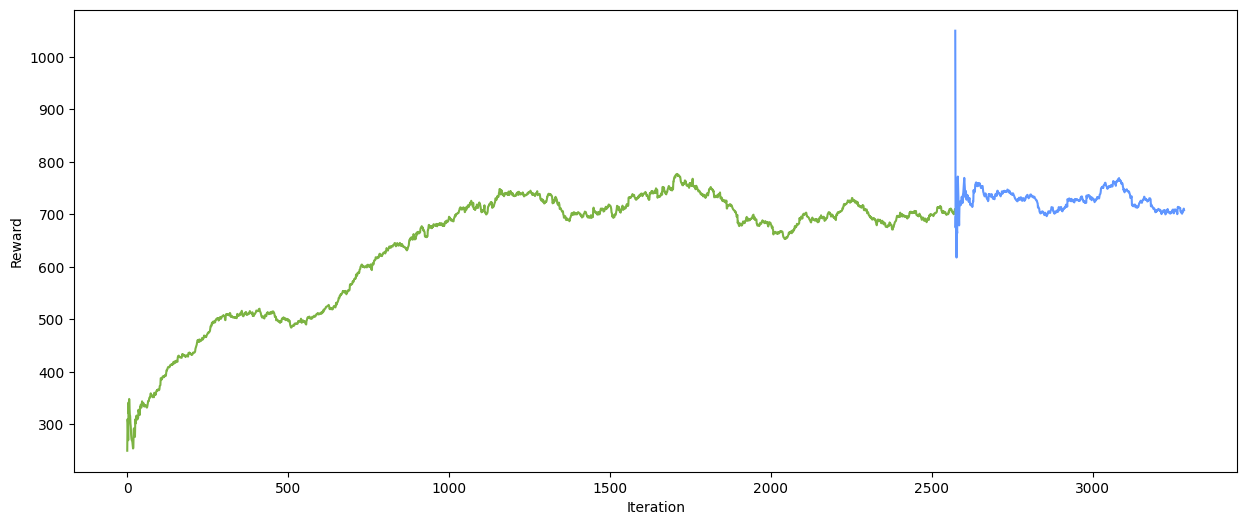

In [7]:
reward_avg1 = first_half[first_half['tag'] == 'reward_avg']['value'].values
reward_avg2 = second_half[second_half['tag'] == 'reward_avg']['value'].values

import numpy as np
import matplotlib.pyplot as plt

# plot them in slightly different colors
plt.figure(figsize=(15,6))
plt.plot(np.arange(len(reward_avg1)), reward_avg1, '#7cb342')
plt.plot(np.arange(len(reward_avg2)) + len(reward_avg1), reward_avg2, '#6096FF')
plt.xlabel('Iteration')
plt.ylabel('Reward')


Text(0, 0.5, 'Reward')

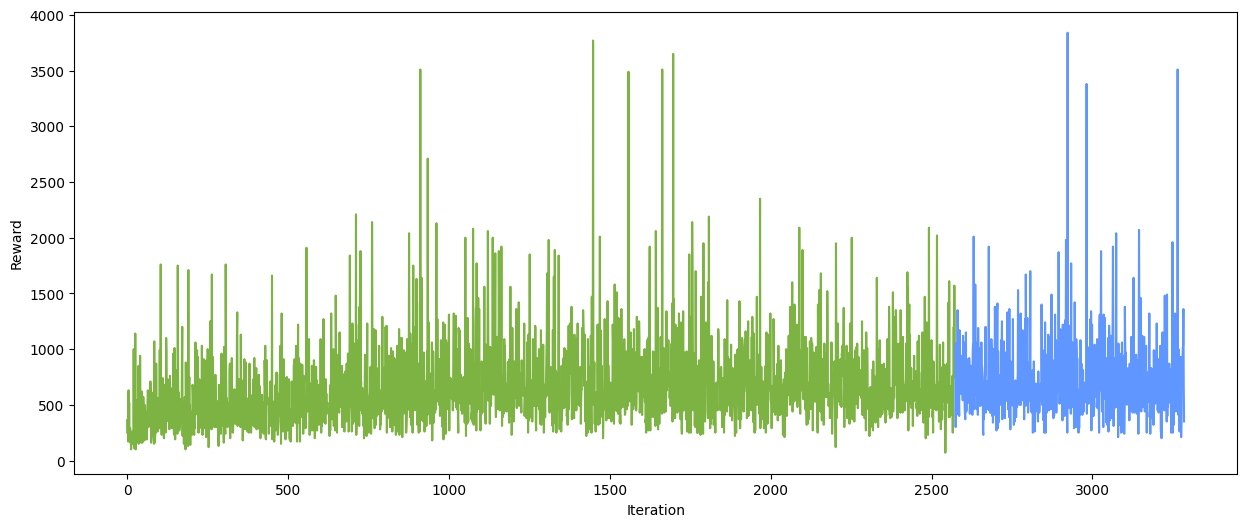

In [8]:
reward_avg1 = first_half[first_half['tag'] == 'reward']['value'].values
reward_avg2 = second_half[second_half['tag'] == 'reward']['value'].values

import numpy as np
import matplotlib.pyplot as plt

# plot them in slightly different colors
plt.figure(figsize=(15,6))
plt.plot(np.arange(len(reward_avg1)), reward_avg1, '#7cb342')
plt.plot(np.arange(len(reward_avg2)) + len(reward_avg1), reward_avg2, '#6096FF')
plt.xlabel('Iteration')
plt.ylabel('Reward')


Text(0, 0.5, 'Reward')

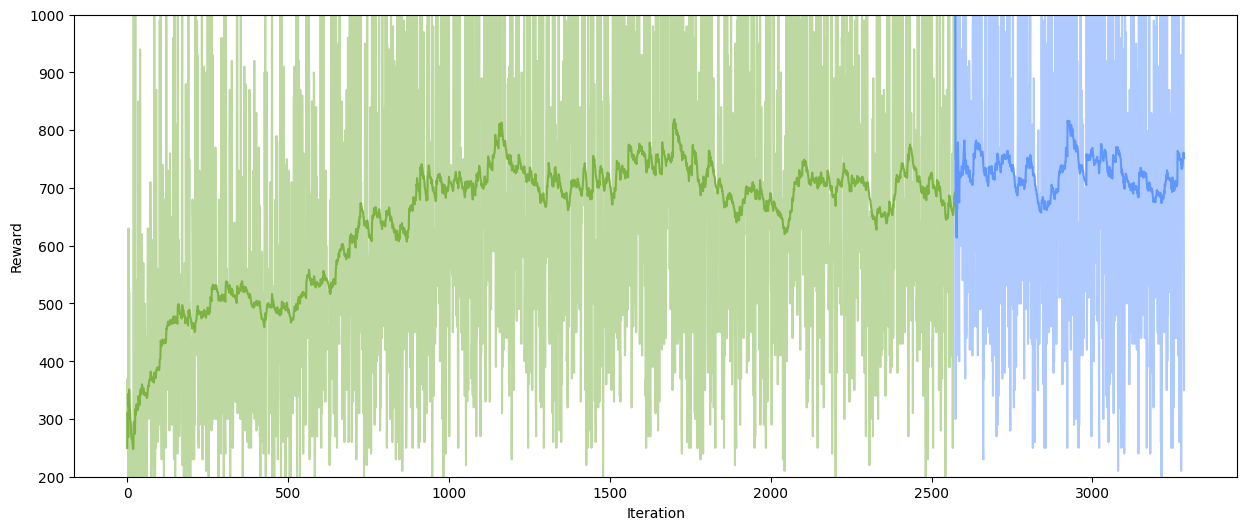

In [9]:
# add smoothed reward
reward_avg1 = first_half[first_half['tag'] == 'reward']['value'].values
reward_avg2 = second_half[second_half['tag'] == 'reward']['value'].values

# plot with exponential moving average
# plot old data with alpha=0.5
# plot new data with alpha=1

import numpy as np
import matplotlib.pyplot as plt

# plot them in slightly different colors
plt.figure(figsize=(15,6))
plt.plot(np.arange(len(reward_avg1)), reward_avg1, '#7cb342', alpha=0.5)
plt.plot(np.arange(len(reward_avg2)) + len(reward_avg1), reward_avg2, '#6096FF', alpha=0.5)

# plot smoothed reward exponential moving average
plt.plot(np.arange(len(reward_avg1)), pd.Series(reward_avg1).ewm(alpha=0.02).mean(), '#7cb342')
plt.plot(np.arange(len(reward_avg2)) + len(reward_avg1), pd.Series(reward_avg2).ewm(alpha=0.02).mean(), '#6096FF')

# y axis, limit to 1500
plt.ylim(200, 1000)
plt.xlabel('Iteration')
plt.ylabel('Reward')

In [10]:
first_half['tag'].unique()

array(['critic_loss', 'kl', 'lenght', 'loss', 'mean_advantage',
       'mean_clipped_ratio', 'mean_logprob', 'mean_ratio', 'reward',
       'reward_avg'], dtype=object)

In [11]:
first_half[first_half['tag'] == 'lenght']['value'].values

array([459., 555., 487., ..., 583., 933., 689.])

2573


Text(0, 0.5, 'Length')

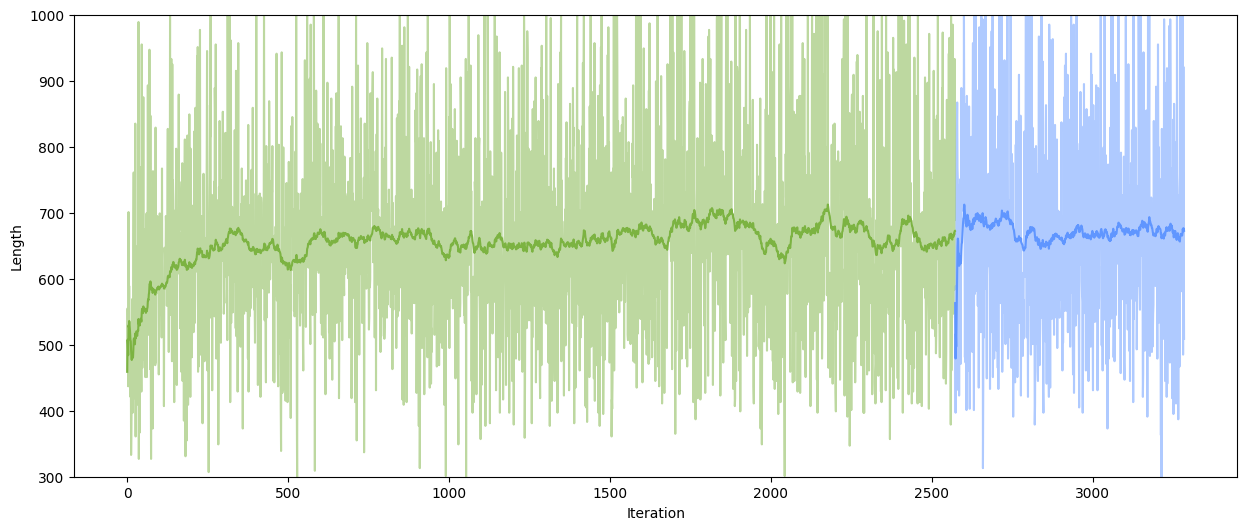

In [12]:
# lenght 
lenght1 = first_half[first_half['tag'] == 'lenght']['value'].values
lenght2 = second_half[second_half['tag'] == 'lenght']['value'].values
print(len(lenght1))
# plot with exponential moving average

import numpy as np
import matplotlib.pyplot as plt

# plot them in slightly different colors
plt.figure(figsize=(15,6))
plt.plot(np.arange(len(lenght1)), lenght1, '#7cb342', alpha=0.5)
plt.plot(np.arange(len(lenght2)) + len(lenght1), lenght2, '#6096FF', alpha=0.5)

# plot smoothed reward exponential moving average
plt.plot(np.arange(len(lenght1)), pd.Series(lenght1).ewm(alpha=0.02).mean(), '#7cb342')
plt.plot(np.arange(len(lenght2)) + len(lenght1), pd.Series(lenght2).ewm(alpha=0.02).mean(), '#6096FF')

# y axis, limit to 1500
plt.ylim(300, 1000)
plt.xlabel('Iteration')
plt.ylabel('Length')

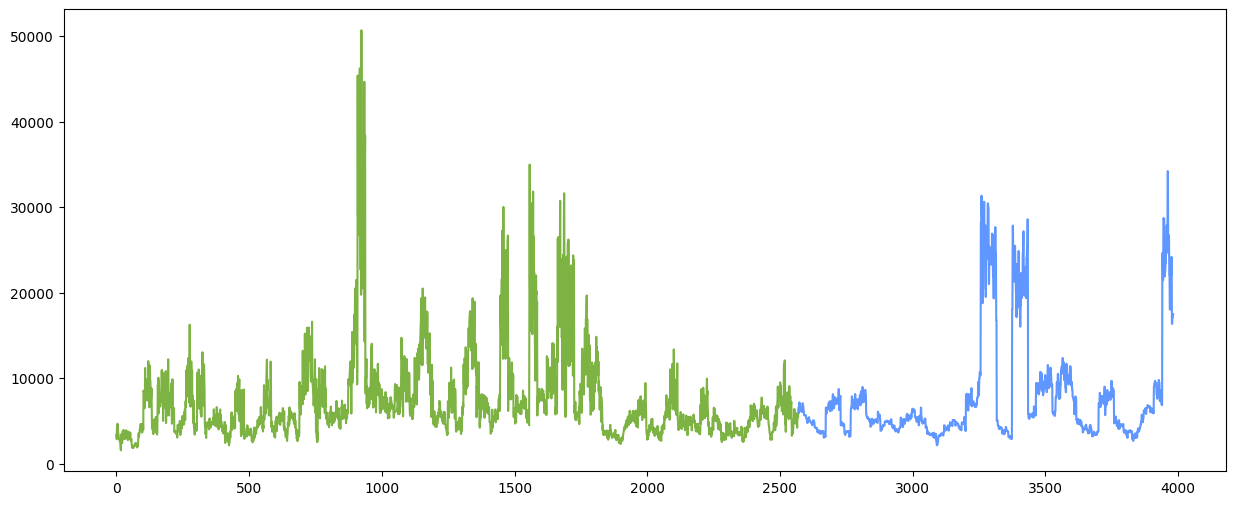

In [13]:
# critic_loss, exponentional moving average
critic_loss1 = first_half[first_half['tag'] == 'critic_loss']['value'].values
critic_loss2 = second_half[second_half['tag'] == 'critic_loss']['value'].values

import numpy as np
import matplotlib.pyplot as plt

# plot them in slightly different colors
plt.figure(figsize=(15,6))
plt.plot(np.arange(len(critic_loss1)), critic_loss1, '#7cb342')
plt.plot(np.arange(len(critic_loss2)) + len(critic_loss1), critic_loss2, '#6096FF')



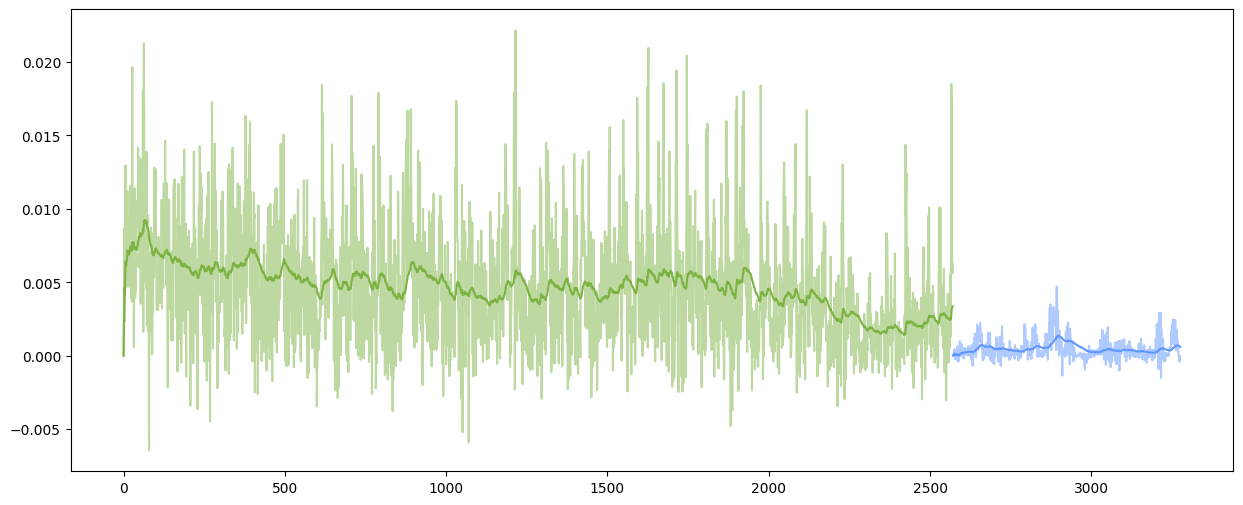

In [14]:
# kl
kl1 = first_half[first_half['tag'] == 'kl']['value'].values
kl2 = second_half[second_half['tag'] == 'kl']['value'].values

import numpy as np
import matplotlib.pyplot as plt

# plot them in slightly different colors
plt.figure(figsize=(15,6))
plt.plot(np.arange(len(kl1)), kl1, '#7cb342', alpha=0.5)
plt.plot(np.arange(len(kl2)) + len(kl1), kl2, '#6096FF', alpha=0.5)

# plot smoothed reward exponential moving average
plt.plot(np.arange(len(kl1)), pd.Series(kl1).ewm(alpha=0.02).mean(), '#7cb342')
plt.plot(np.arange(len(kl2)) + len(kl1), pd.Series(kl2).ewm(alpha=0.02).mean(), '#6096FF')


In [15]:
# 20231203-143539v5.0

data = get_training_chain('20231203-143539v5.0')

run: 
    ### 20231203-143539
    #### 2023-12-03 14:35:40
    ---
    ## params
    - env_name: ALE/MsPacman-v5
- version: v5.0
- DRY_RUN: False
- actor_lr: 1e-06
- critic_lr: 0.0001
- action_space: 9
- observation_space_raw: (6, 210, 160, 3)
- observation_space: (85, 50, 6)
- episodes: 100000
- max_steps_per_episode: 1200
- discount_rate: 0.99
- eps_decay_len: 1000
- eps_min: 0.1
- clip_ratio: 0.2
- lam: 0.98
- curius_coef: 0.08
- batch_size: 4000
- batch_size_curius: 300
- train_interval: 1
- iters: 100
- save_freq: 500
- resumed: resumed from: MsPacman-v5v5.0_20231203-122828_1000
    
resumed_from: 20231203-122828v5.0
run: 
    ### 20231203-122828
    #### 2023-12-03 12:28:29
    ---
    ## params
    - env_name: ALE/MsPacman-v5
- version: v5.0
- DRY_RUN: False
- actor_lr: 1e-05
- critic_lr: 0.001
- action_space: 9
- observation_space_raw: (6, 210, 160, 3)
- observation_space: (85, 50, 6)
- episodes: 100000
- max_steps_per_episode: 1200
- discount_rate: 0.99
- eps_decay_len: 1000
-

In [16]:
data # experiment with high reward in pacman

['20231203-143539v5.0',
 '20231203-122828v5.0',
 '20231203-102206v5.0',
 '20231202-145122v5.0',
 '20231202-095624v5.0',
 '20231201-232739v5.0']

In [17]:
# load scalars
scalars = [load_scalars(x) for x in data]
# reverse 
scalars = scalars[::-1]
# take only the first 3
scalars = scalars[:3]

In [260]:
# define function that will take series and plot it
def plot_series(series, alpha=0.02, smooth=True, color=0, stroke_width=None, same_color: bool = False):
    # plot every series with alpha=0.5, concatenate them
    total_length = 0
    for i, s in enumerate(series):
        plt.plot(np.arange(len(s))+total_length, s, alpha=0.5 if smooth else 1, color=f'C{i+color}' if not same_color else f'C{color}', linewidth=stroke_width)
        total_length += len(s)
    # plot smoothed reward exponential moving 
    if smooth:
        total_length = 0
        for i, s in enumerate(series):
            plt.plot(np.arange(len(s))+total_length, pd.Series(s).ewm(alpha=alpha).mean(), color=f'C{i+color}' if not same_color else f'C{color}')
            total_length += len(s) 

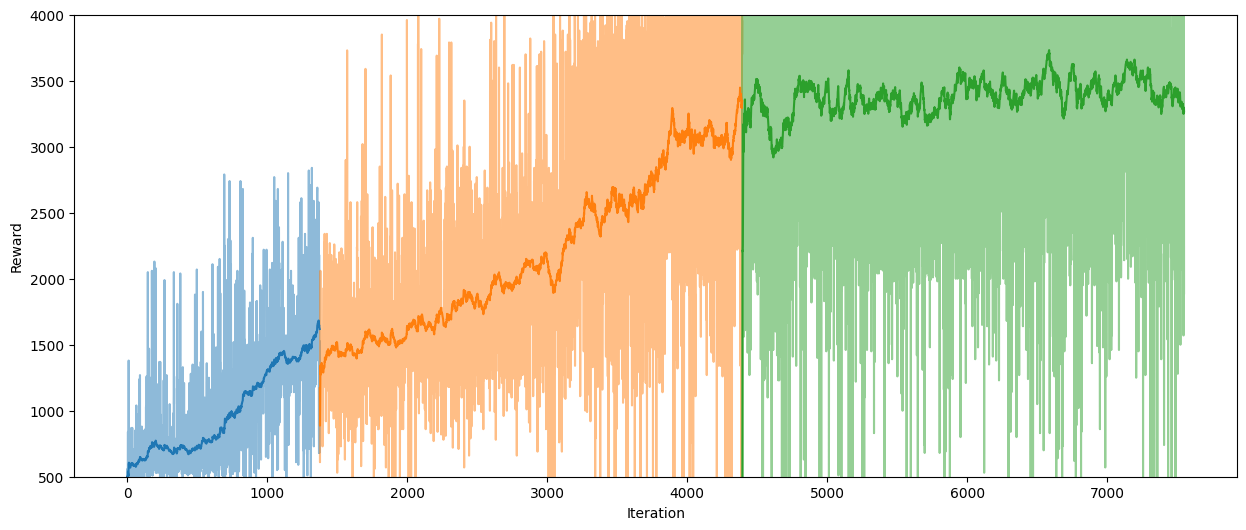

In [19]:
def concat_all_series(series):
    return np.concatenate([x['value'].values for x in series])
def get_tag(series, tag):
    return [x[x['tag'] == tag]['value'].values for x in series]
# plot reward
plt.figure(figsize=(15,6))
rewards = get_tag(scalars, 'reward')
plt.ylim(500, 4000)
plt.xlabel('Iteration')
plt.ylabel('Reward')
plot_series(rewards)

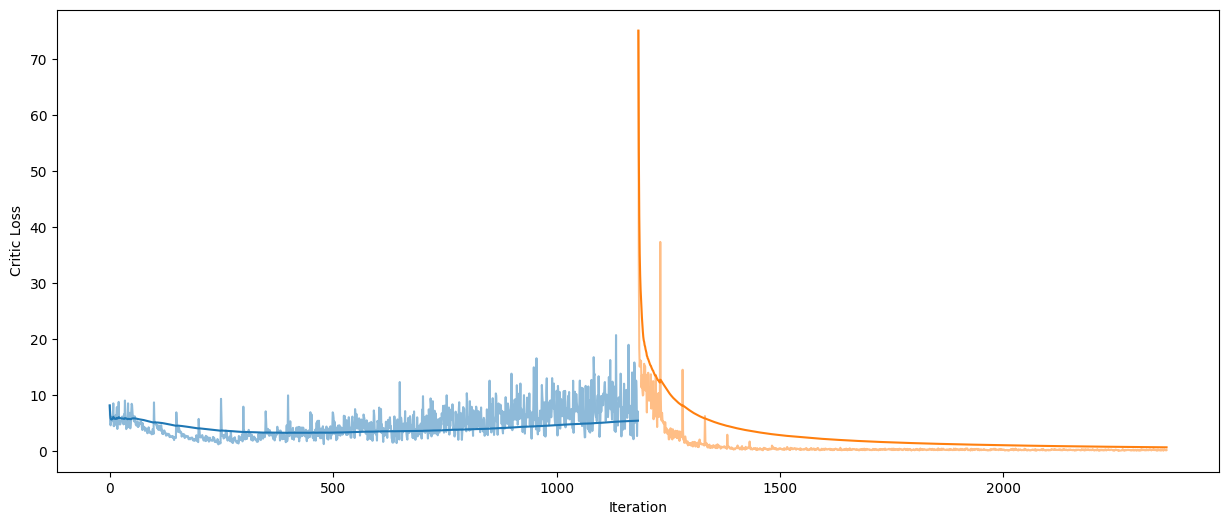

In [262]:
def concat_all_series(series):
    return np.concatenate([x['value'].values for x in series])
def get_tag(series, tag):
    return [x[x['tag'] == tag]['value'].values for x in series]
def concat(series):
    return np.concatenate(series)
# plot reward
plt.figure(figsize=(15,6))
rewards = get_tag(scalars, 'critic_loss')
plt.xlabel('Iteration')
plt.ylabel('Critic Loss')
plot_series(rewards, alpha=0.001)

In [21]:
# pacman models to investigate training
models = [
    # v1 - deep Q learning & setup baseline
          "v1.0_20231110-191738",
          "v1.1_20231110-194154",
          "v1.2_20231110-211047",
          "v1.3_20231111-062608",
          "v1.3_20231111-204750",
          "v1.4_20231112-072446",
          "v1.5_20231113-081445",

          # v2 - ppo

          "v3.0_20231118-164415",
          "v3.0_20231119-084807",
          "v3.0_20231120-085344",
          "v3.0_20231120-085344",
          "v3.0_20231121-211759",

          # v5 - ppo with curiosity
          "v5.0_20231203-143539",

          # v6 - ppo with curiosity on autoencoded states
          "v6.1_20231216-114110",]
versions, dates = zip(*[x.split('_') for x in models])
traces_base_names = [f'{date}{version}' for date, version in zip(dates, versions)]
traces_base_names

['20231110-191738v1.0',
 '20231110-194154v1.1',
 '20231110-211047v1.2',
 '20231111-062608v1.3',
 '20231111-204750v1.3',
 '20231112-072446v1.4',
 '20231113-081445v1.5',
 '20231118-164415v3.0',
 '20231119-084807v3.0',
 '20231120-085344v3.0',
 '20231120-085344v3.0',
 '20231121-211759v3.0',
 '20231203-143539v5.0',
 '20231216-114110v6.1']

In [22]:
traces = [get_training_chain(x) for x in traces_base_names]

run: 
    ### 20231110-191738
    #### 2023-11-10 19:17:39
    ---
    ## params
    - env_name: ALE/MsPacman-v5
- version: v1.0
- DRY_RUN: False
- lr: 0.00025
- action_space: 9
- observation_space_raw: (210, 160, 3)
- observation_space: (84, 84, 3)
- episodes: 10000
- max_steps_per_episode: 1000
- discount_rate: 0.99
- eps_decay_len: 10
- eps_min: 0.1
- batch_size: 64
- train_interval: 3
- target_update_freq: 100
- save_freq: 100
- resumed: resumed from: MsPacman-v5v1.0_20231110-190002_500.h5
    
resumed_from: 20231110-190002v1.0
run: 
    ### 20231110-190002
    #### 2023-11-10 19:00:03
    ---
    ## params
    - env_name: ALE/MsPacman-v5
- version: v1.0
- DRY_RUN: False
- lr: 0.003
- action_space: 9
- observation_space_raw: (210, 160, 3)
- observation_space: (84, 84, 3)
- episodes: 10000
- max_steps_per_episode: 1000
- discount_rate: 0.99
- eps_decay_len: 10
- eps_min: 0.1
- batch_size: 128
- train_interval: 4
- target_update_freq: 100
- save_freq: 100
- resumed: resumed from: MsP

In [23]:
traces

[['20231110-191738v1.0', '20231110-190002v1.0', '20231110-180505v1.0'],
 ['20231110-194154v1.1'],
 ['20231110-211047v1.2'],
 ['20231111-062608v1.3'],
 ['20231111-204750v1.3', '20231111-121119v1.3'],
 ['20231112-072446v1.4', '20231112-001140v1.4'],
 ['20231113-081445v1.5'],
 ['20231118-164415v3.0',
  '20231118-093101v3.0',
  '20231117-214859v3.0',
  '20231117-201208v3.0'],
 ['20231119-084807v3.0'],
 ['20231120-085344v3.0',
  '20231119-205646v3.0',
  '20231119-181604v3.0',
  '20231119-143458v3.0',
  '20231119-084807v3.0'],
 ['20231120-085344v3.0',
  '20231119-205646v3.0',
  '20231119-181604v3.0',
  '20231119-143458v3.0',
  '20231119-084807v3.0'],
 ['20231121-211759v3.0',
  '20231120-085344v3.0',
  '20231119-205646v3.0',
  '20231119-181604v3.0',
  '20231119-143458v3.0',
  '20231119-084807v3.0'],
 ['20231203-143539v5.0',
  '20231203-122828v5.0',
  '20231203-102206v5.0',
  '20231202-145122v5.0',
  '20231202-095624v5.0',
  '20231201-232739v5.0'],
 ['20231216-114110v6.1',
  '20231215-145255v6

In [24]:
# import markdown rendere
from IPython.display import Markdown as md

# display traces
markdown = ''
for i, trace in enumerate(traces):
    md_trace = f'### {i} - {trace[0]}\n'
    for t in trace:
        md_trace += f' - {t}\n'
    markdown += md_trace

md(markdown)

### 0 - 20231110-191738v1.0
 - 20231110-191738v1.0
 - 20231110-190002v1.0
 - 20231110-180505v1.0
### 1 - 20231110-194154v1.1
 - 20231110-194154v1.1
### 2 - 20231110-211047v1.2
 - 20231110-211047v1.2
### 3 - 20231111-062608v1.3
 - 20231111-062608v1.3
### 4 - 20231111-204750v1.3
 - 20231111-204750v1.3
 - 20231111-121119v1.3
### 5 - 20231112-072446v1.4
 - 20231112-072446v1.4
 - 20231112-001140v1.4
### 6 - 20231113-081445v1.5
 - 20231113-081445v1.5
### 7 - 20231118-164415v3.0
 - 20231118-164415v3.0
 - 20231118-093101v3.0
 - 20231117-214859v3.0
 - 20231117-201208v3.0
### 8 - 20231119-084807v3.0
 - 20231119-084807v3.0
### 9 - 20231120-085344v3.0
 - 20231120-085344v3.0
 - 20231119-205646v3.0
 - 20231119-181604v3.0
 - 20231119-143458v3.0
 - 20231119-084807v3.0
### 10 - 20231120-085344v3.0
 - 20231120-085344v3.0
 - 20231119-205646v3.0
 - 20231119-181604v3.0
 - 20231119-143458v3.0
 - 20231119-084807v3.0
### 11 - 20231121-211759v3.0
 - 20231121-211759v3.0
 - 20231120-085344v3.0
 - 20231119-205646v3.0
 - 20231119-181604v3.0
 - 20231119-143458v3.0
 - 20231119-084807v3.0
### 12 - 20231203-143539v5.0
 - 20231203-143539v5.0
 - 20231203-122828v5.0
 - 20231203-102206v5.0
 - 20231202-145122v5.0
 - 20231202-095624v5.0
 - 20231201-232739v5.0
### 13 - 20231216-114110v6.1
 - 20231216-114110v6.1
 - 20231215-145255v6.1
 - 20231214-094337v6.1
 - 20231213-202645v6.1
 - 20231213-160232v6.1
 - 20231212-081441v6.1
 - 20231211-172155v6.1


# V1

In [180]:
v1 = traces[0]
scalars_v1 = [load_scalars(x) for x in v1][::-1]
scalars_v1[0]['tag'].unique()


array(['actor_loss', 'critic_loss', 'lenght', 'loss', 'reward',
       'reward_avg'], dtype=object)

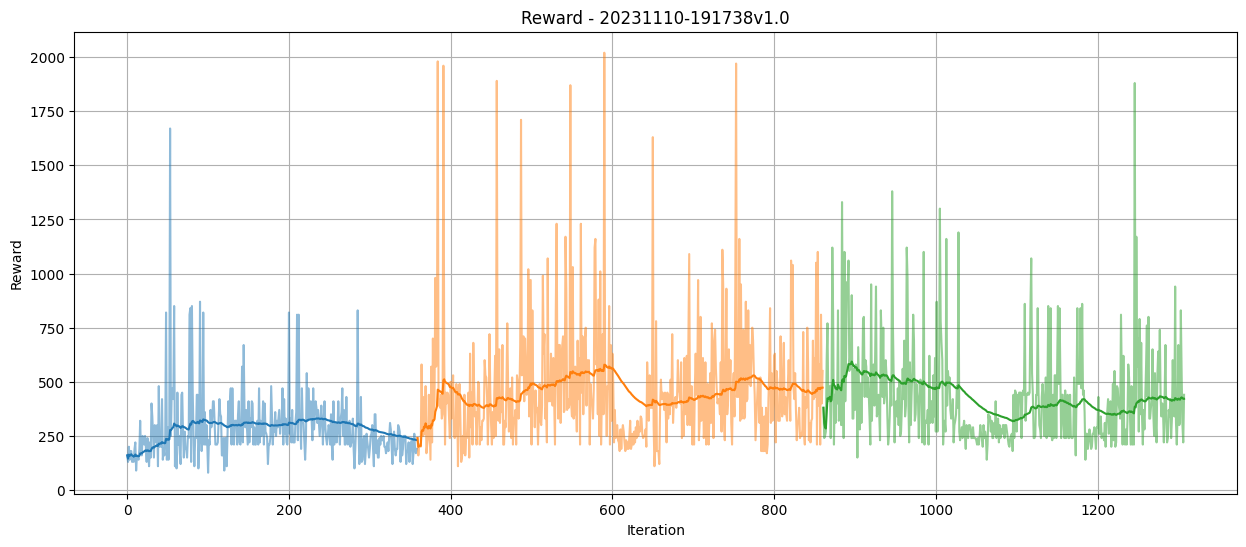

In [284]:
# plot reward, critic loss, kl and avg reward observation_space: (84, 84, 3)
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_v1, 'reward')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231110-191738v1.0')
plt.grid()
plot_series(rewards)

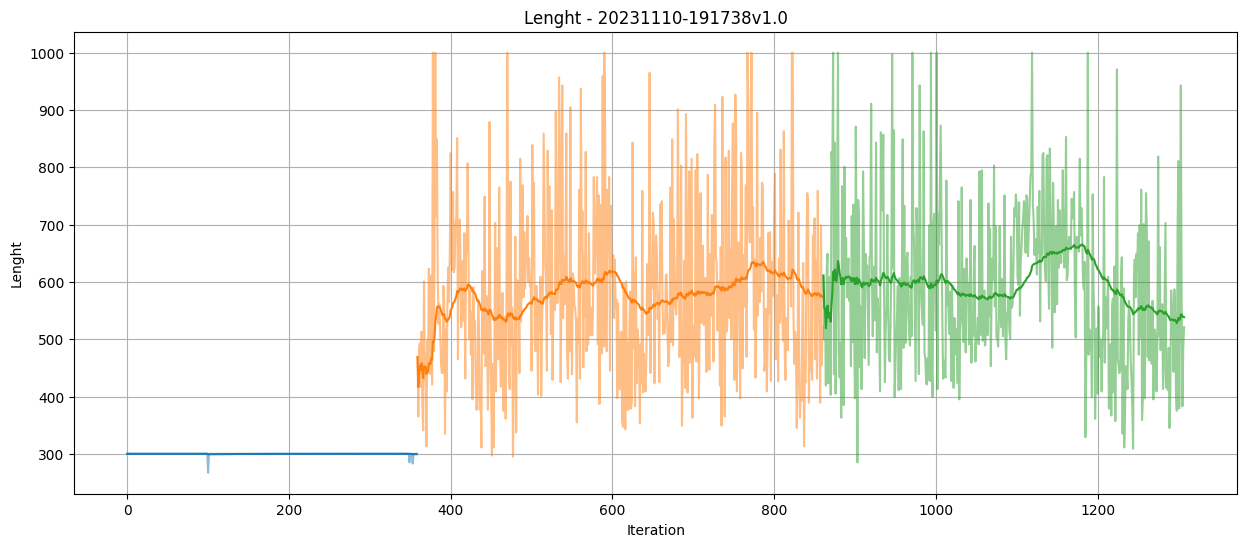

In [229]:
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_v1, 'lenght')
plt.xlabel('Iteration')
plt.ylabel('Lenght')
plt.title('Lenght - 20231110-191738v1.0')
plt.grid()
plot_series(rewards)

In [129]:
# notatka: ten przebieg posiada duży eps_decay i posiada observation_space: (84, 84, 3)
v11 = traces[4]
scalars_v11 = [load_scalars(x) for x in v11][::-1]
scalars_v11[0]['tag'].unique()

array(['actor_loss', 'critic_loss', 'lenght', 'loss', 'reward',
       'reward_avg'], dtype=object)

# V1.3

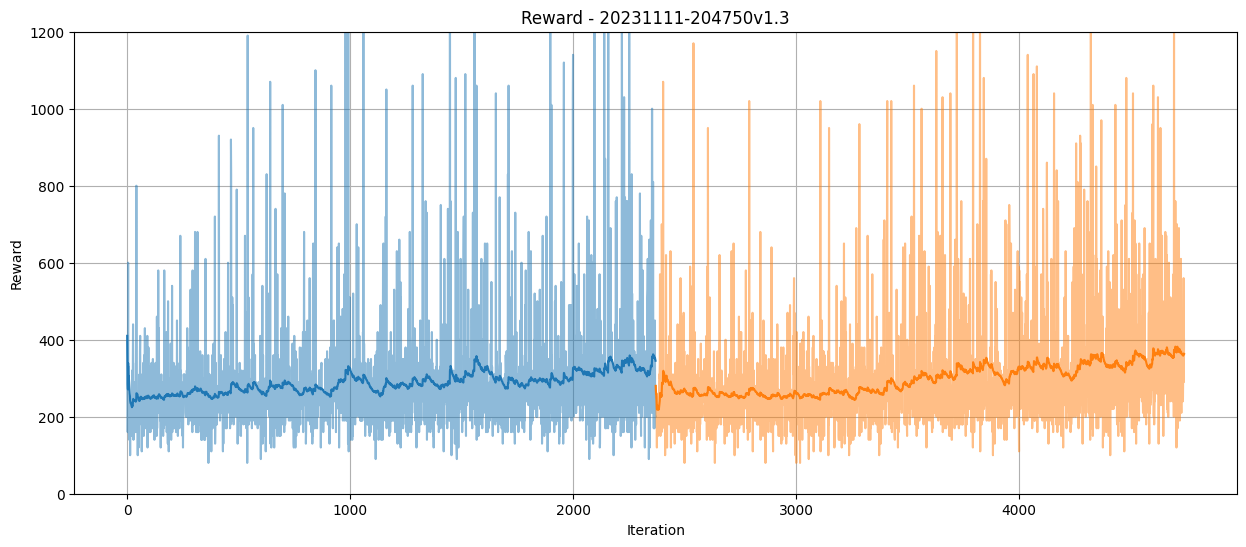

In [438]:
# plot reward, critic loss, kl and avg reward
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_v11, 'reward')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231111-204750v1.3')
plt.ylim(0, 1200)
plt.grid()
plot_series(rewards)

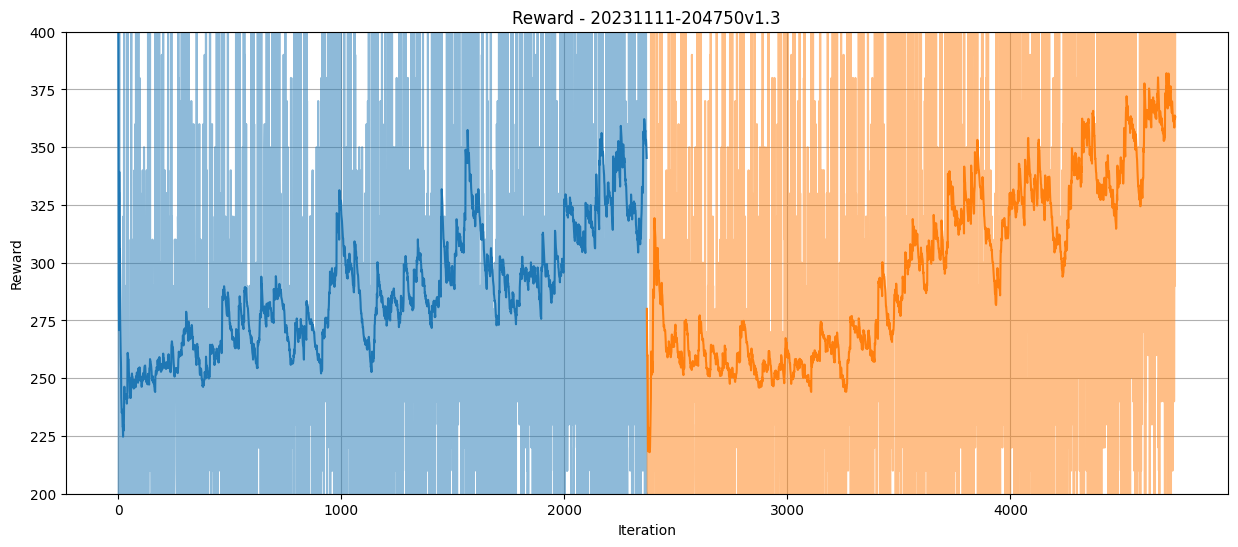

In [436]:
# plot reward, critic loss, kl and avg reward
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_v11, 'reward')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231111-204750v1.3')
plt.ylim(200, 400)
plt.grid()
plot_series(rewards)

In [132]:
# eps_decay_len: 4000, batch_size: 2048 7 godzin uczenia
v12 = traces[5]
scalars_v12 = [load_scalars(x) for x in v12][::-1]
scalars_v12[0]['tag'].unique()

array(['actor_loss', 'critic_loss', 'lenght', 'loss', 'reward',
       'reward_avg'], dtype=object)

# V1.4

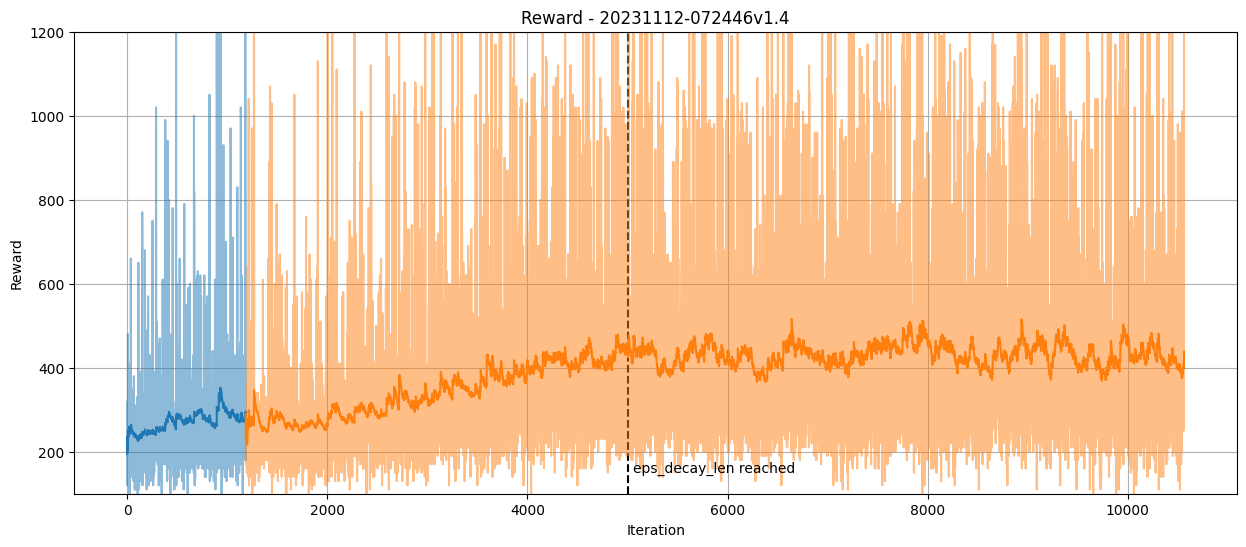

In [226]:

plt.figure(figsize=(15,6))
rewards = get_tag(scalars_v12, 'reward')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231112-072446v1.4')
# add doted line on 4000 with label eps_decay_len = 4000
plt.axvline(5000, color='black', linestyle='--')
plt.text(5050, 150, 'eps_decay_len reached')
plt.ylim(100, 1200)
plt.grid()
plot_series(rewards)

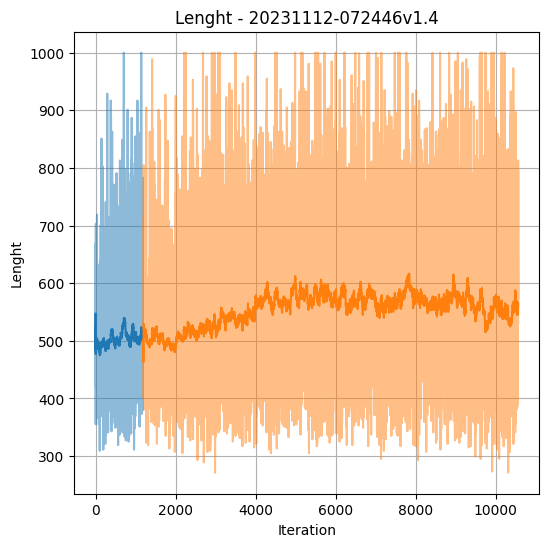

In [451]:
plt.figure(figsize=(6,6))
rewards = get_tag(scalars_v12, 'lenght')
plt.xlabel('Iteration')
plt.ylabel('Lenght')
plt.title('Lenght - 20231112-072446v1.4')
plt.grid()
plot_series(rewards)

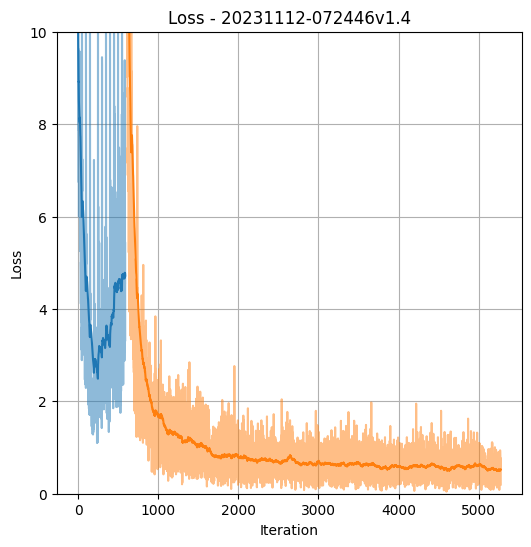

In [450]:
plt.figure(figsize=(6,6))
rewards = get_tag(scalars_v12, 'loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss - 20231112-072446v1.4')
plt.grid()
plt.ylim(0, 10)
plot_series(rewards)

In [134]:
v3_first = get_training_chain('20231118-093101v3.0')

run: 
    ### 20231118-093101
    #### 2023-11-18 09:31:02
    ---
    ## params
    - env_name: ALE/MsPacman-v5
- version: v3.0
- DRY_RUN: False
- actor_lr: 7e-05
- critic_lr: 0.0003
- action_space: 9
- observation_space_raw: (2, 210, 160, 3)
- observation_space: (85, 50, 6)
- episodes: 100000
- max_steps_per_episode: 1000
- discount_rate: 0.995
- clip_ratio: 0.25
- lam: 0.97
- batch_size: 4096
- train_interval: 4
- iters: 1
- save_freq: 300
- resumed: resumed from: MsPacman-v5v3.0_20231117-214859_1200
    
resumed_from: 20231117-214859v3.0
run: 
    ### 20231117-214859
    #### 2023-11-17 21:49:00
    ---
    ## params
    - env_name: ALE/MsPacman-v5
- version: v3.0
- DRY_RUN: False
- actor_lr: 7e-05
- critic_lr: 0.0003
- action_space: 9
- observation_space_raw: (2, 210, 160, 3)
- observation_space: (85, 50, 6)
- episodes: 100000
- max_steps_per_episode: 1000
- discount_rate: 0.995
- clip_ratio: 0.25
- lam: 0.97
- batch_size: 4096
- train_interval: 4
- iters: 1
- save_freq: 300
- res

# V3 (PPO)

In [135]:
# load scalars
scalars_v3 = [load_scalars(x) for x in v3_first][::-1]
scalars_v3[0]['tag'].unique()

array(['critic_loss', 'kl', 'lenght', 'loss', 'mean_advantage',
       'mean_clipped_ratio', 'mean_logprob', 'mean_ratio', 'reward',
       'reward_avg'], dtype=object)

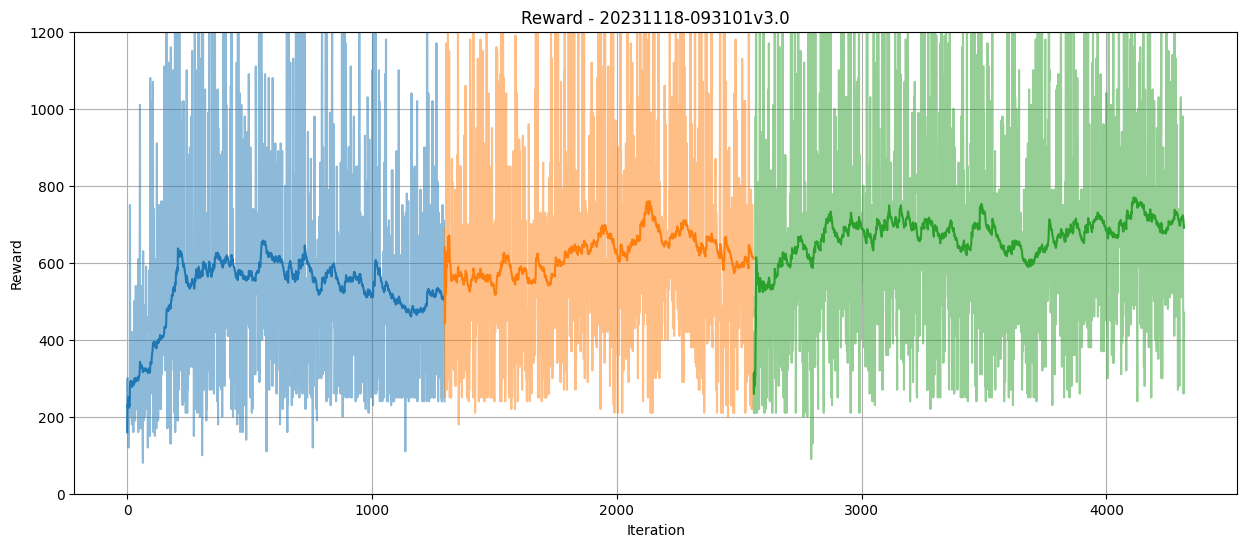

In [231]:
# pierwsze podejście do ppo, observation_space: observation_space: (85, 50, 6) (dwie klatki kolorowe)
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_v3, 'reward')
plt.ylim(0, 1200)
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.grid()
plt.title('Reward - 20231118-093101v3.0')
plot_series(rewards)

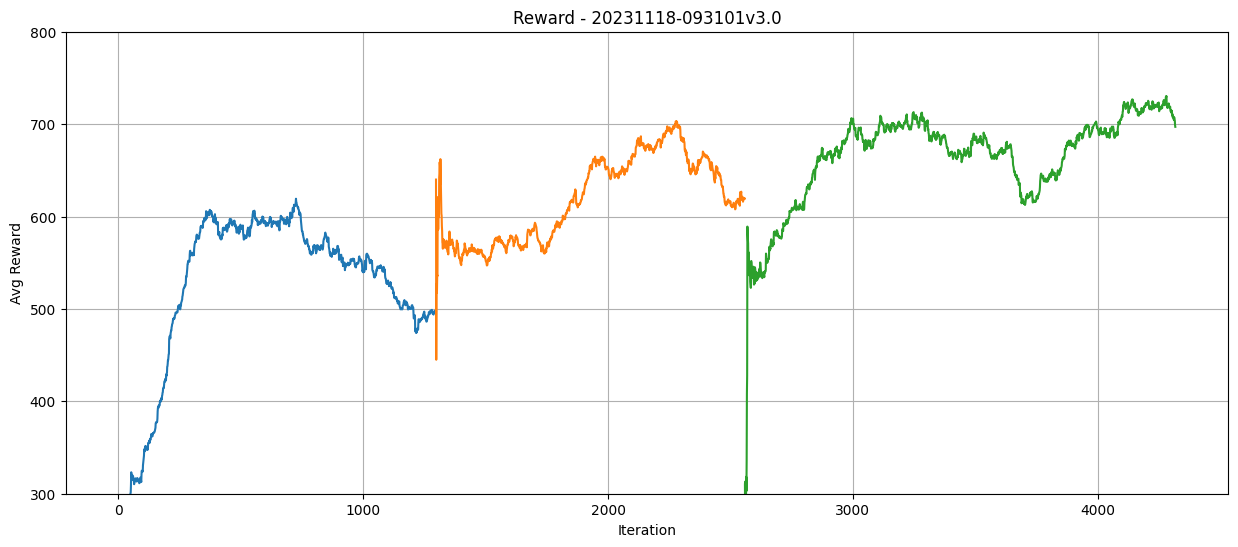

In [232]:
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_v3, 'reward_avg')
plt.ylim(300, 800)
plt.xlabel('Iteration')
plt.ylabel('Avg Reward')
plt.grid()
plt.title('Reward - 20231118-093101v3.0')
plot_series(rewards, smooth=False)

In [141]:
# 20231119-084807v3.0(7)
scalars_2v3 = [load_scalars(x) for x in traces[8]][::-1]
scalars_2v3[0]['tag'].unique()

array(['critic_loss', 'kl', 'lenght', 'loss', 'mean_advantage',
       'mean_clipped_ratio', 'mean_logprob', 'mean_ratio', 'reward',
       'reward_avg'], dtype=object)

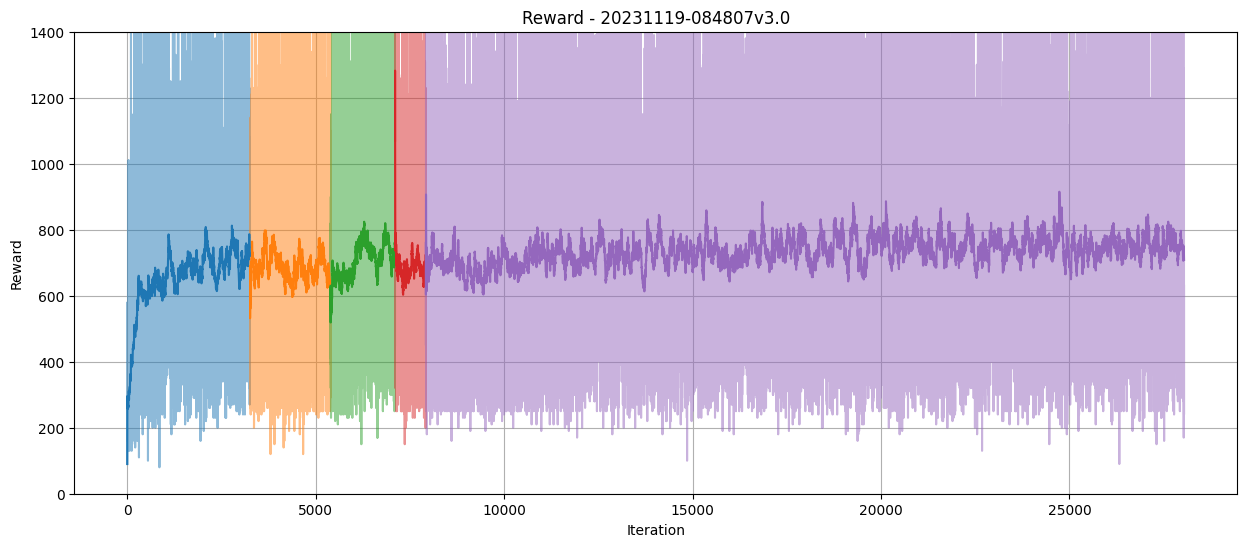

In [225]:
# plot reward, critic loss, kl and avg reward
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_2v3, 'reward')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.grid()
plt.title('Reward - 20231119-084807v3.0')
plt.ylim(0, 1400)
plot_series(rewards)

In [158]:
scalars_3v3 = [load_scalars(x) for x in traces[10]][::-1]
scalars_3v3[0]['tag'].unique()

array(['critic_loss', 'kl', 'lenght', 'loss', 'mean_advantage',
       'mean_clipped_ratio', 'mean_logprob', 'mean_ratio', 'reward',
       'reward_avg'], dtype=object)

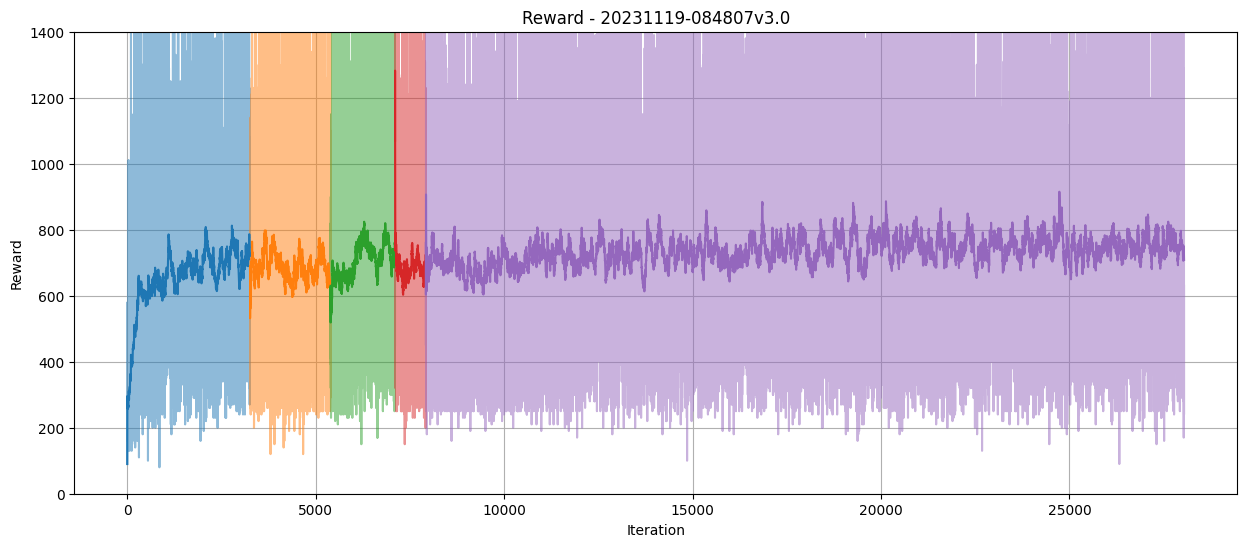

In [224]:
# observation_space: (85, 50, 6) 
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_3v3, 'reward')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231119-084807v3.0')
plt.grid()
plt.ylim(0, 1400)
plot_series(rewards)

In [160]:
scalars_4v3 = [load_scalars(x) for x in traces[11]][::-1]
scalars_4v3[0]['tag'].unique()

array(['critic_loss', 'kl', 'lenght', 'loss', 'mean_advantage',
       'mean_clipped_ratio', 'mean_logprob', 'mean_ratio', 'reward',
       'reward_avg'], dtype=object)

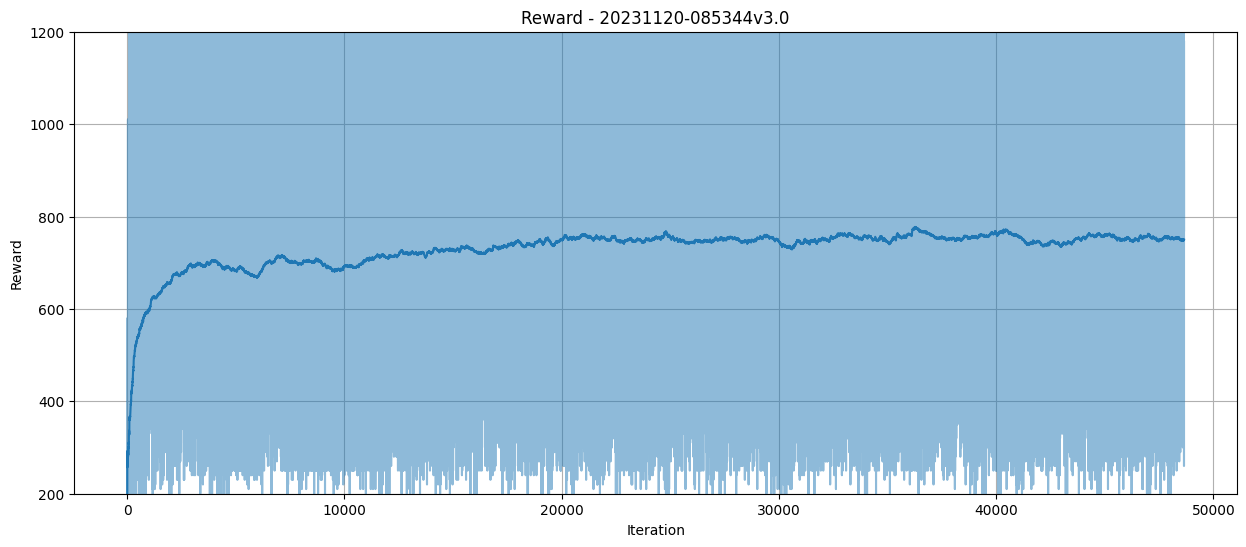

In [266]:
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_4v3, 'reward')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231120-085344v3.0')
plt.grid()
plt.ylim(200, 1200)
plot_series([concat(rewards)], alpha=0.001)

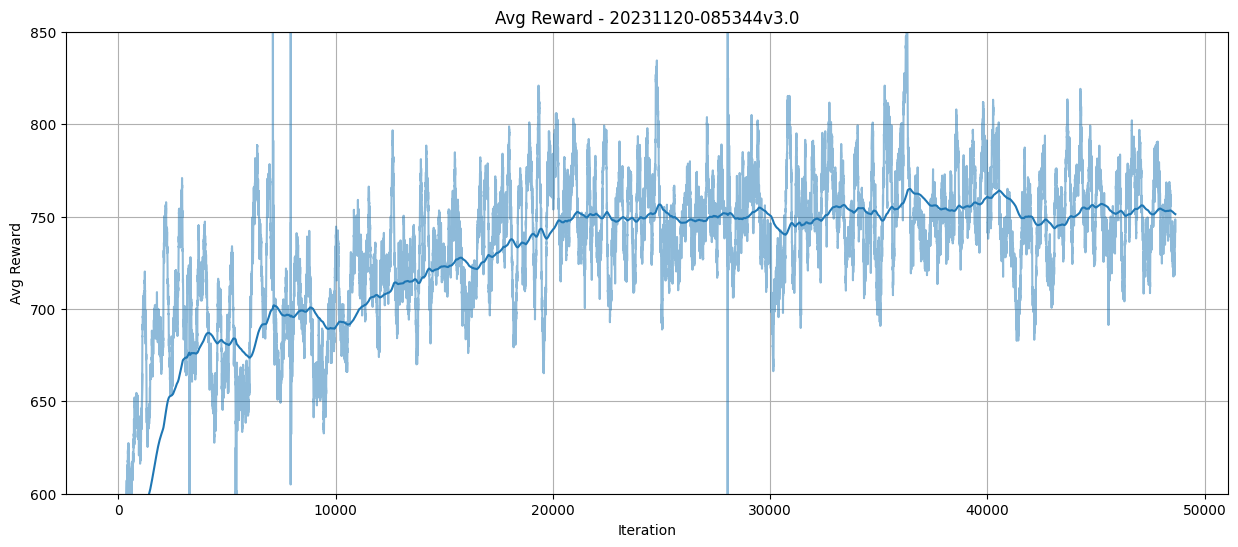

In [265]:
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_4v3, 'reward_avg')
plt.xlabel('Iteration')
plt.ylabel('Avg Reward')
plt.title('Avg Reward - 20231120-085344v3.0')
plt.grid()
plt.ylim(600, 850)
plot_series([concat(rewards)], alpha=0.0005)

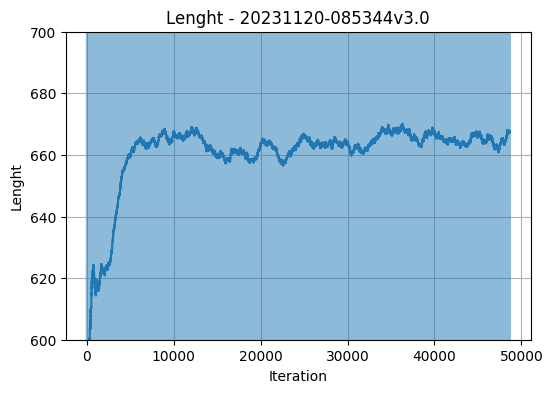

In [264]:
plt.figure(figsize=(6,4))
rewards = get_tag(scalars_4v3, 'lenght')
plt.xlabel('Iteration')
plt.ylabel('Lenght')
plt.title('Lenght - 20231120-085344v3.0')
plt.grid()
plt.ylim(600, 700)
plot_series([concat(rewards)], alpha=0.0005)

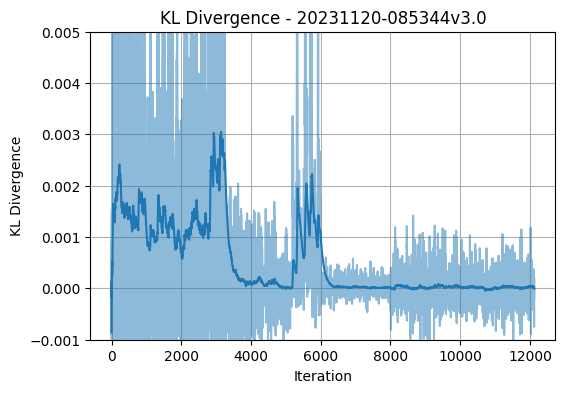

In [270]:
plt.figure(figsize=(6,4))
rewards = get_tag(scalars_4v3, 'kl')
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')
plt.title('KL Divergence - 20231120-085344v3.0')
plt.grid()
plt.ylim(-0.001, 0.005)
plot_series([concat(rewards)], alpha=0.01)

In [171]:
# load 20231123-184012v4.0
v4_first = get_training_chain('20231123-184012v4.0')
v4_first

run: 
    ### 20231123-184012
    #### 2023-11-23 18:40:13
    ---
    ## params
    - env_name: ALE/MsPacman-v5
- version: v4.0
- DRY_RUN: False
- actor_lr: 1e-06
- critic_lr: 3e-05
- action_space: 9
- observation_space_raw: (6, 210, 160, 3)
- observation_space: (85, 50, 6)
- episodes: 100000
- max_steps_per_episode: 1000
- discount_rate: 0.995
- eps_decay_len: 1000
- eps_min: 0.1
- clip_ratio: 0.2
- lam: 0.97
- batch_size: 4096
- train_interval: 1
- iters: 2
- save_freq: 1000
- resumed: resumed from: MsPacman-v5v4.0_20231123-152347_2000
    
resumed_from: 20231123-152347v4.0
run: 
    ### 20231123-152347
    #### 2023-11-23 15:23:48
    ---
    ## params
    - env_name: ALE/MsPacman-v5
- version: v4.0
- DRY_RUN: False
- actor_lr: 3e-05
- critic_lr: 0.0001
- action_space: 9
- observation_space_raw: (6, 210, 160, 3)
- observation_space: (85, 50, 6)
- episodes: 100000
- max_steps_per_episode: 1000
- discount_rate: 0.995
- eps_decay_len: 1000
- eps_min: 0.1
- clip_ratio: 0.2
- lam: 0.97


['20231123-184012v4.0', '20231123-152347v4.0']

In [172]:
# load scalars
scalars_v4 = [load_scalars(x) for x in v4_first][::-1]
scalars_v4[0]['tag'].unique()

array(['critic_loss', 'kl', 'lenght', 'loss', 'mean_advantage',
       'mean_clipped_ratio', 'mean_logprob', 'mean_ratio', 'reward',
       'reward_avg'], dtype=object)

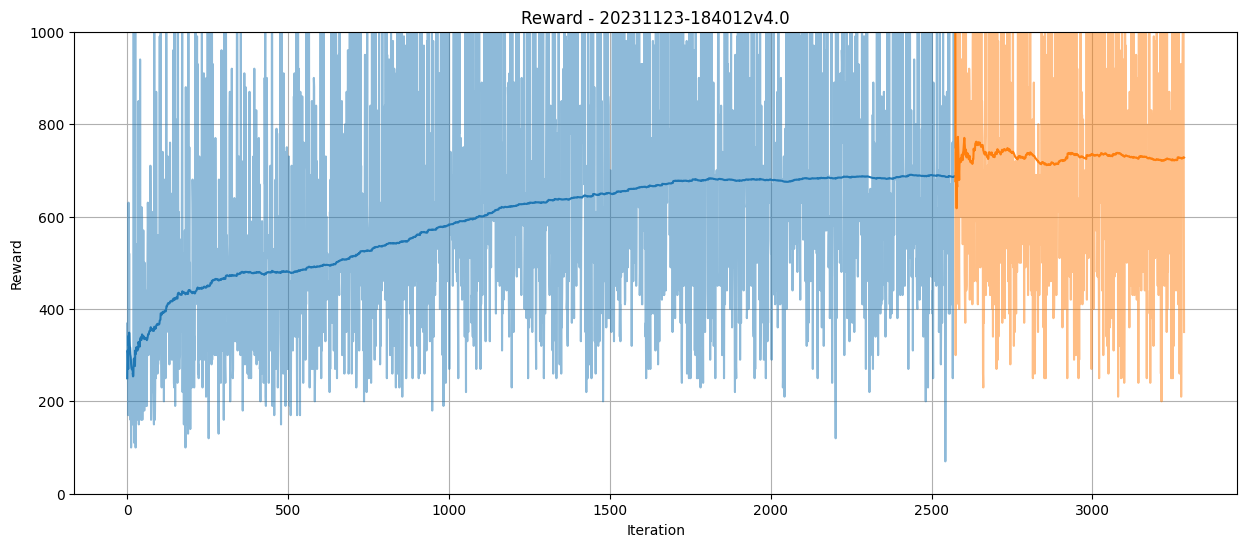

In [274]:
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_v4, 'reward')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231123-184012v4.0')
plt.grid()
plt.ylim(0, 1000)
plot_series(rewards, alpha=0.001)

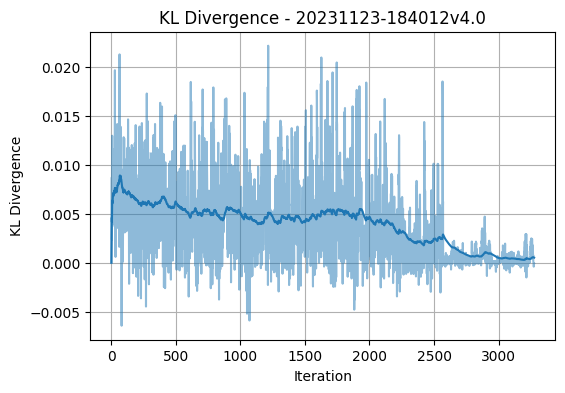

In [282]:
plt.figure(figsize=(6,4))
rewards = get_tag(scalars_v4, 'kl')
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')
plt.title('KL Divergence - 20231123-184012v4.0')
plt.grid()

plot_series([concat(rewards)], alpha=0.01)

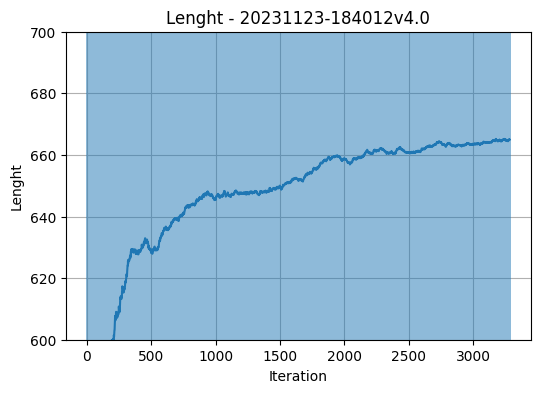

In [283]:
plt.figure(figsize=(6,4))
rewards = get_tag(scalars_v4, 'lenght')
plt.xlabel('Iteration')
plt.ylabel('Lenght')
plt.title('Lenght - 20231123-184012v4.0')
plt.grid()
plt.ylim(600, 700)
plot_series([concat(rewards)], alpha=0.0005)

# Sumup (v1-v4)

Text(0, 0.5, 'Reward')

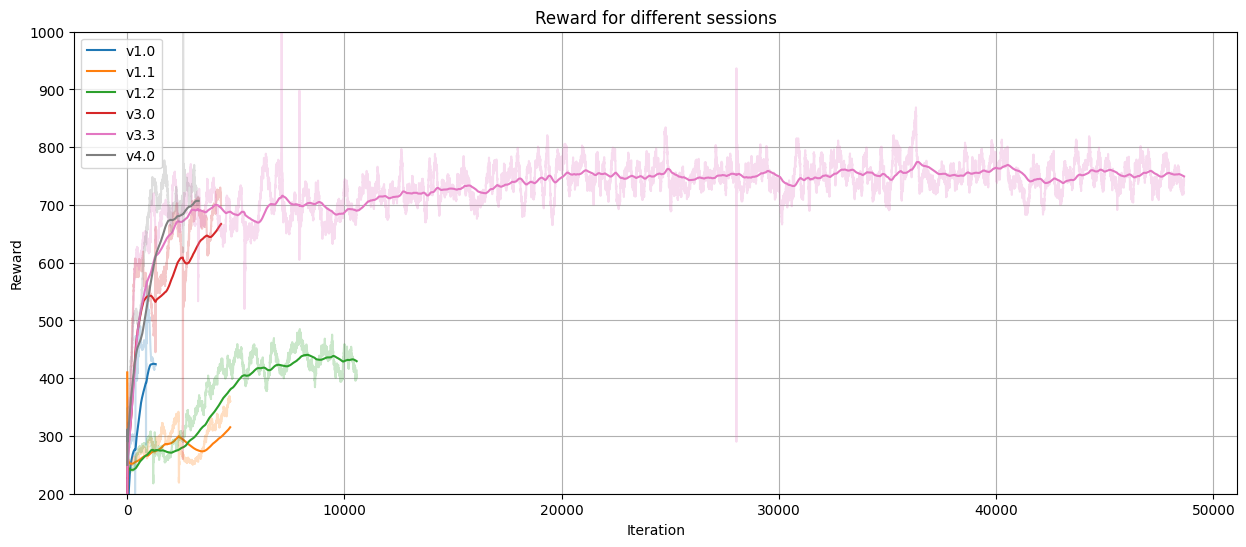

In [236]:
# plot them all together
plt.figure(figsize=(15,6))

alpha = 0.25
def plot_normal(label, color, scalar):
    plt.plot(concat(get_tag(scalar, 'reward_avg')), color=color, alpha=alpha)
    plt.plot(pd.DataFrame(concat(get_tag(scalar, 'reward_avg'))).ewm(alpha=0.001).mean(), label=label, color=color)

plot_normal('v1.0', 'C0', scalars_v1)
plot_normal('v1.1', 'C1', scalars_v11)
plot_normal('v1.2', 'C2', scalars_v12)
plot_normal('v3.0', 'C3', scalars_v3)
plot_normal('v3.3', 'C6', scalars_4v3)
plot_normal('v4.0', 'C7', scalars_v4)

plt.legend()
plt.grid()
plt.ylim(200, 1000)
plt.title('Reward for different sessions')
plt.xlabel('Iteration')
plt.ylabel('Reward')

Text(0, 0.5, 'Reward')

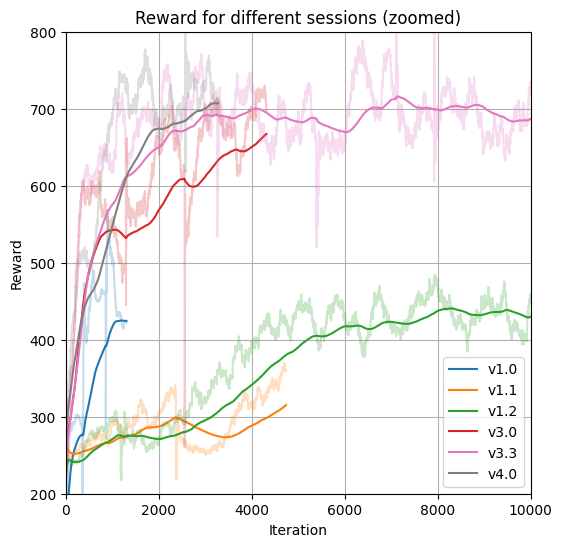

In [235]:
plt.figure(figsize=(6,6))
plot_normal('v1.0', 'C0', scalars_v1)
plot_normal('v1.1', 'C1', scalars_v11)
plot_normal('v1.2', 'C2', scalars_v12)
plot_normal('v3.0', 'C3', scalars_v3)
plot_normal('v3.3', 'C6', scalars_4v3)
plot_normal('v4.0', 'C7', scalars_v4)

plt.legend()
plt.grid()
plt.ylim(200, 800)
plt.xlim(0, 10000)
plt.title('Reward for different sessions (zoomed)')
plt.xlabel('Iteration')
plt.ylabel('Reward')

# Curiousity (v5, v6)

In [285]:
# 12
scalars_v5 = [load_scalars(x) for x in traces[12]][::-1]
scalars_v5[0]['tag'].unique() 

array(['critic_loss', 'curiosity_loss', 'curiosity_mean', 'curiosity_std',
       'curiosity_sum', 'kl', 'lenght', 'loss', 'mean_clipped_ratio',
       'mean_logprob', 'mean_ratio', 'reward', 'reward_avg'], dtype=object)

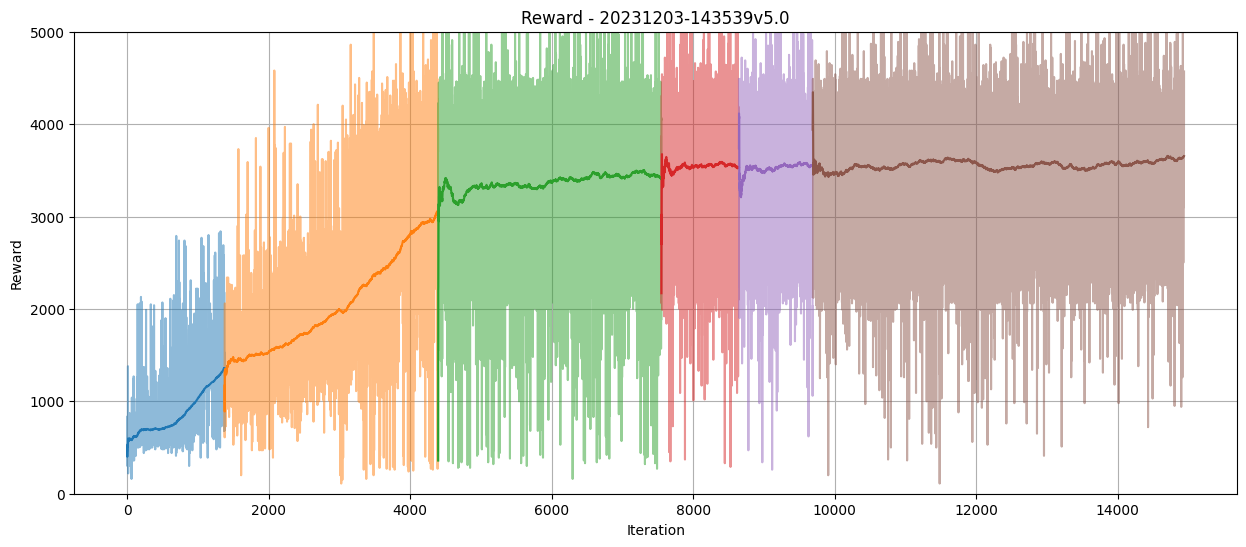

In [336]:
# plot reward as always
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_v5, 'reward')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231203-143539v5.0')
plt.grid()
plt.ylim(0, 5000)
plot_series(rewards, alpha=0.003)

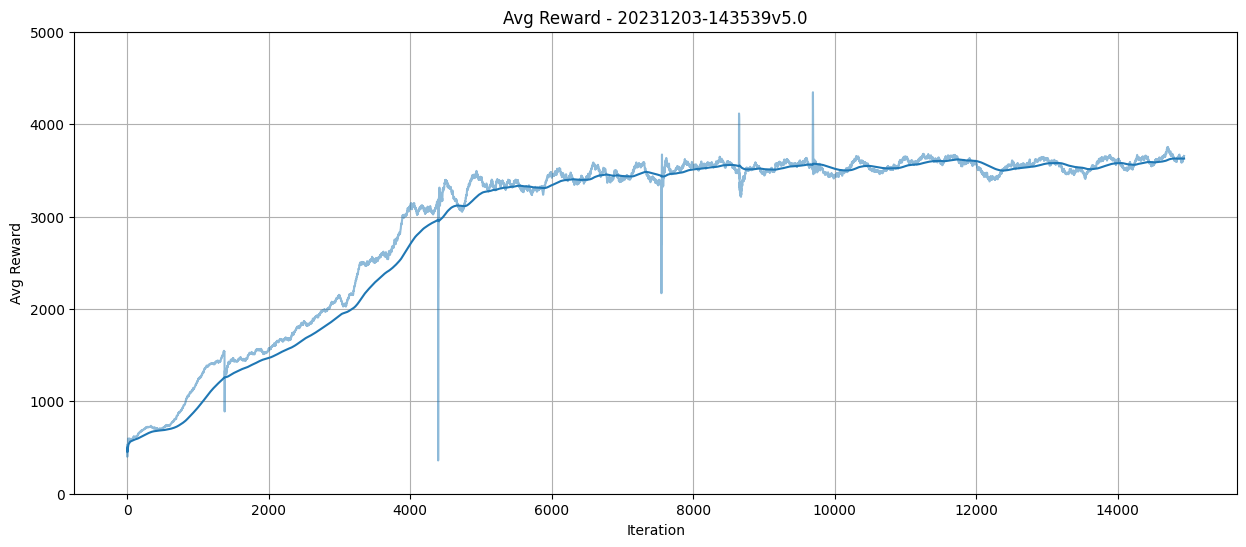

In [337]:
plt.figure(figsize=(15,6))
rewards = get_tag(scalars_v5, 'reward_avg')
plt.xlabel('Iteration')
plt.ylabel('Avg Reward')
plt.title('Avg Reward - 20231203-143539v5.0')
plt.grid()
plt.ylim(0, 5000)
plot_series([concat(rewards)], alpha=0.003)

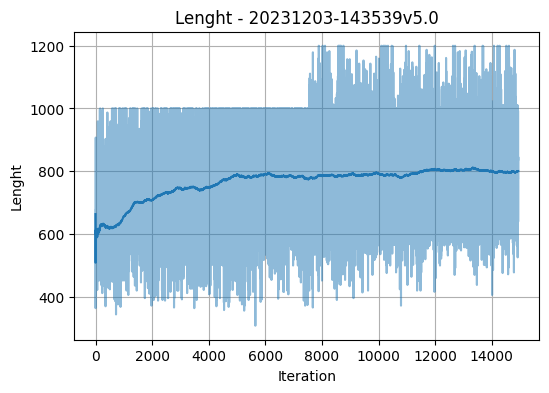

In [338]:
plt.figure(figsize=(6,4))
rewards = get_tag(scalars_v5, 'lenght')
plt.xlabel('Iteration')
plt.ylabel('Lenght')
plt.title('Lenght - 20231203-143539v5.0')
plt.grid()
plot_series([concat(rewards)], alpha=0.002)

# V5
Nagły wzrost średniej nagrody wywołał wzrost błędu w krytyku, gdy nagrody przestały rosnąć, błąd krytyka zaczął spadać
Inne warości na x bo wartości krytyka są obliczane tylko podczas uczenia (nie w każdym epizodzie)

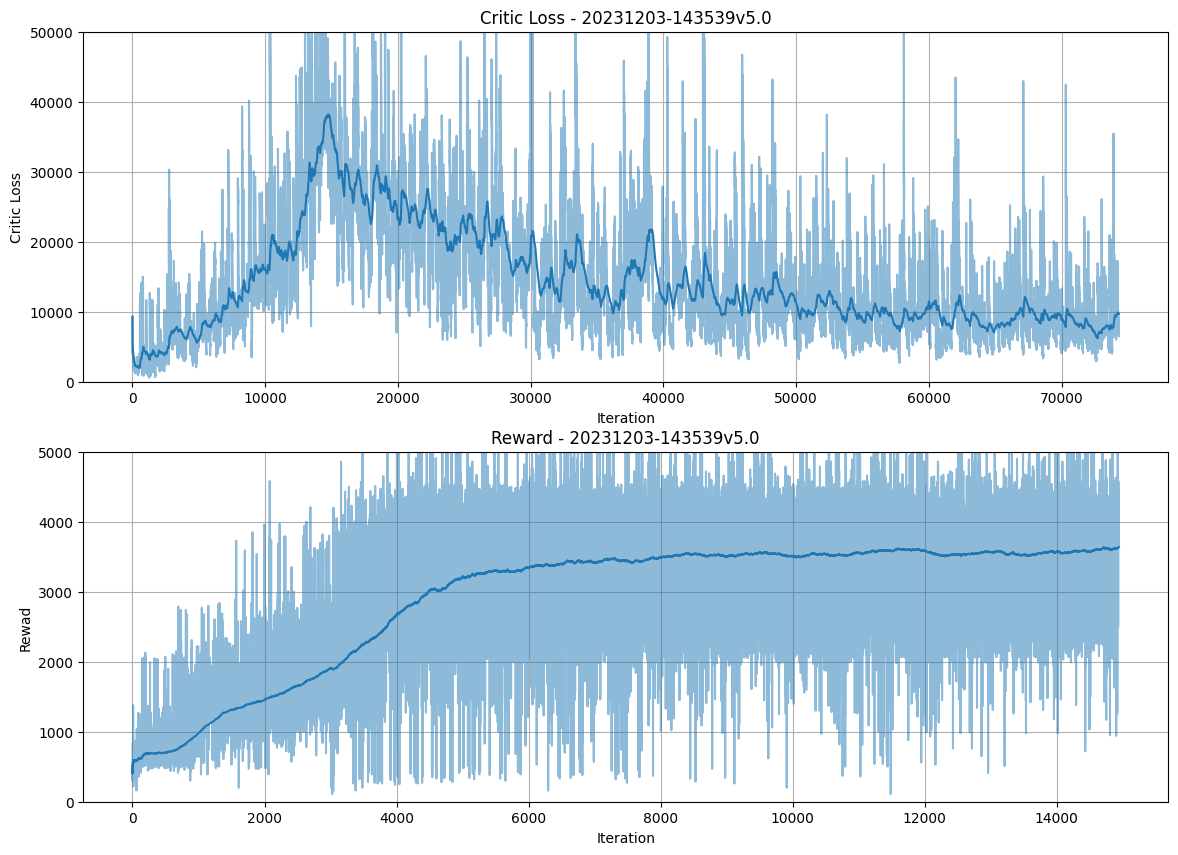

In [317]:
fig, ax = plt.subplots(2, 1, figsize=(14,10))
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Critic Loss')
ax[0].set_title('Critic Loss - 20231203-143539v5.0')
ax[0].grid()
ax[0].set_ylim(0, 50000)
# set ax[0] default plt
plt.sca(ax[0])
plot_series([concat(get_tag(scalars_v5, 'critic_loss'))], alpha=0.002)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Rewad')
ax[1].set_title('Reward - 20231203-143539v5.0')
ax[1].grid()
ax[1].set_ylim(0, 5000)
# set ax[1] default plt
plt.sca(ax[1])
plot_series([concat(get_tag(scalars_v5, 'reward'))], alpha=0.002)

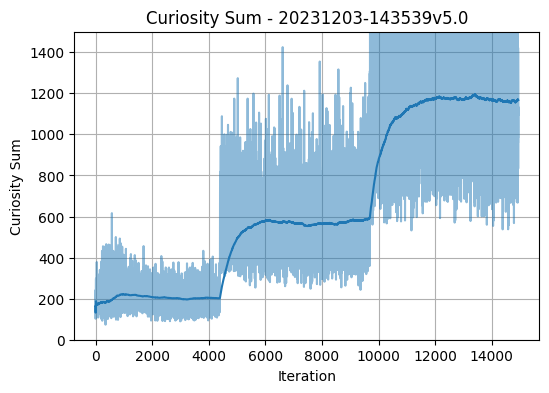

In [324]:
plt.figure(figsize=(6,4))
rewards = get_tag(scalars_v5, 'curiosity_sum')
plt.xlabel('Iteration')
plt.ylabel('Curiosity Sum')
plt.title('Curiosity Sum - 20231203-143539v5.0')
plt.ylim(0, 1500)
plt.grid()
plot_series([concat(rewards)], alpha=0.002)

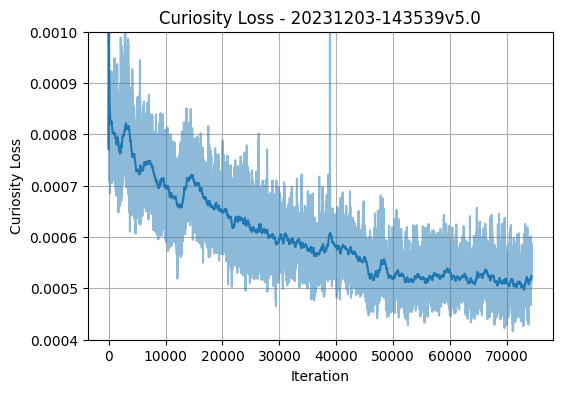

In [332]:
plt.figure(figsize=(6,4))
rewards = get_tag(scalars_v5, 'curiosity_loss')
plt.xlabel('Iteration')
plt.ylabel('Curiosity Loss')
plt.title('Curiosity Loss - 20231203-143539v5.0')
plt.grid()
plt.ylim(0.0004, 0.001)
plot_series([concat(rewards)], alpha=0.002)

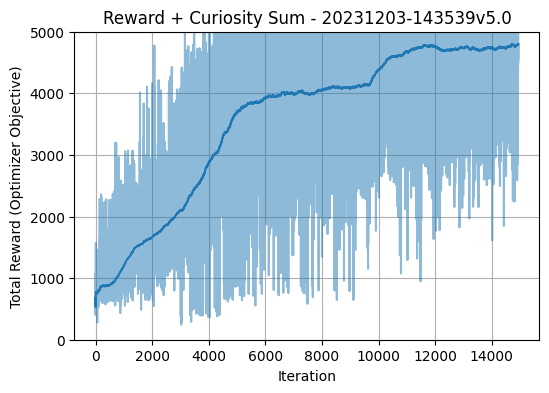

In [359]:
plt.figure(figsize=(6,4))
rewards = get_tag(scalars_v5, 'curiosity_sum')
plt.xlabel('Iteration')
plt.ylabel('Total Reward (Optimizer Objective)')
plt.title('Reward + Curiosity Sum - 20231203-143539v5.0')
plt.grid()
plt.ylim(0, 5000)
total_reward = concat(get_tag(scalars_v5, 'reward')) + concat([concat(get_tag(scalars_v5, 'curiosity_sum')), [0]])
plot_series([total_reward], alpha=0.002)

# v6.1
Zmodyfikowane nagrody

In [383]:
# 13
scalars_v6 = [load_scalars(x) for x in traces[13]][::-1]

scalars_v6[0]['tag'].unique()

array(['autoencoder_loss', 'critic_loss', 'curiosity_loss',
       'curiosity_mean', 'curiosity_std', 'curiosity_sum', 'kl', 'lenght',
       'loss', 'mean_clipped_ratio', 'mean_logprob', 'mean_ratio',
       'reward', 'reward_avg'], dtype=object)

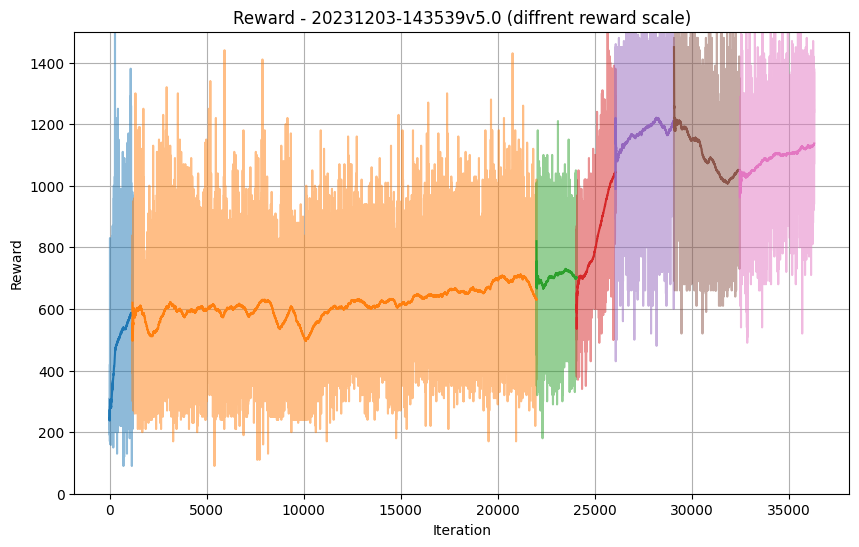

In [357]:
# plot reward as always
plt.figure(figsize=(10,6))
rewards = get_tag(scalars_v6, 'reward')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231203-143539v5.0 (diffrent reward scale)')
plt.grid()
plt.ylim(0, 1500)
plot_series(rewards, alpha=0.003)

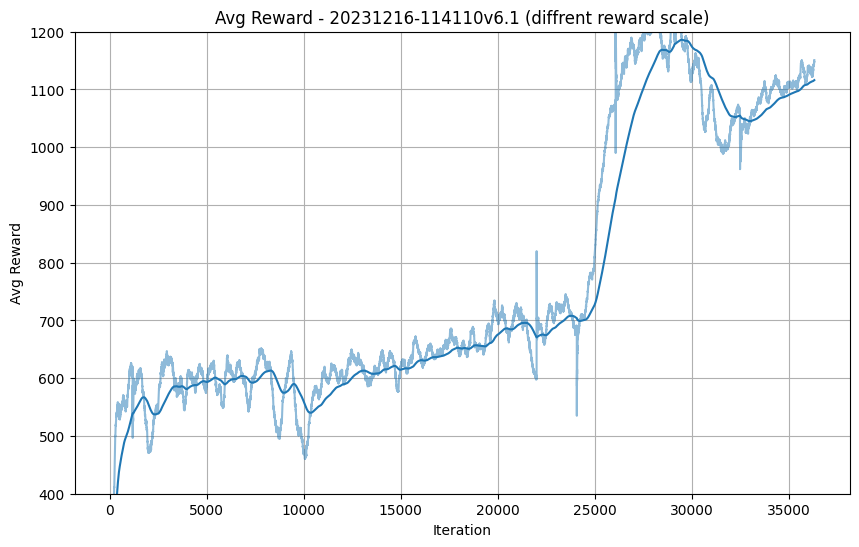

In [356]:
# plot reward as always
plt.figure(figsize=(10,6))
rewards = get_tag(scalars_v6, 'reward_avg')
plt.xlabel('Iteration')
plt.ylabel('Avg Reward')
plt.title('Avg Reward - 20231216-114110v6.1 (scaled rewards)')
plt.grid()
plt.ylim(400, 1200)
plot_series([concat(rewards)], alpha=0.001)

In [353]:
# scale reward
sampled_avg_reward = 1611.84 # avg from 40 games 
# get reward_avg from scalars_v6[-1] at step 3000 (latast model)
reward_avg = scalars_v6[-1][scalars_v6[-1]['tag'] == 'reward_avg']['value'].values[3000]
scale_ratio = sampled_avg_reward/reward_avg
scale_ratio

1.4477388380519929

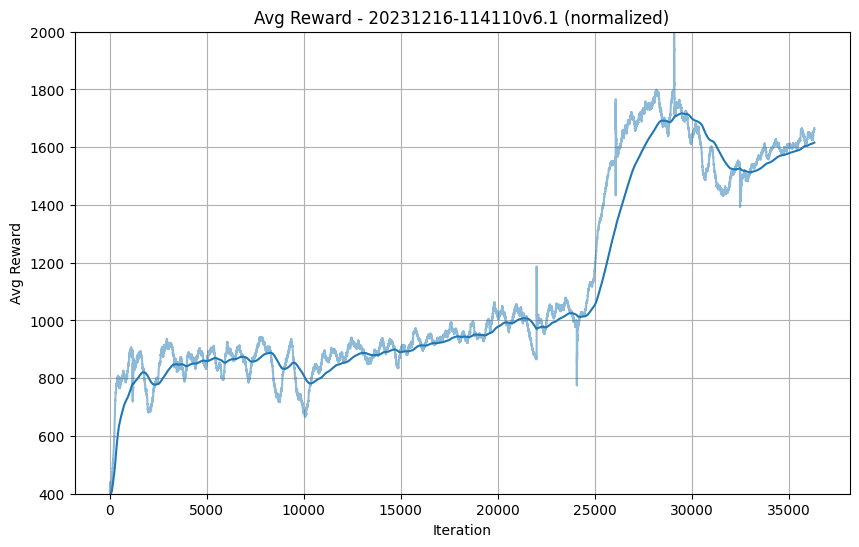

In [355]:
# scale plot by scale_ratio
# plot reward as always
plt.figure(figsize=(10,6))
rewards = get_tag(scalars_v6, 'reward_avg')
rewards = concat(rewards) * scale_ratio
plt.xlabel('Iteration')
plt.ylabel('Avg Reward')
plt.title('Avg Reward - 20231216-114110v6.1 (normalized)')
plt.grid()
plt.ylim(400, 2000)
plot_series([rewards], alpha=0.001)

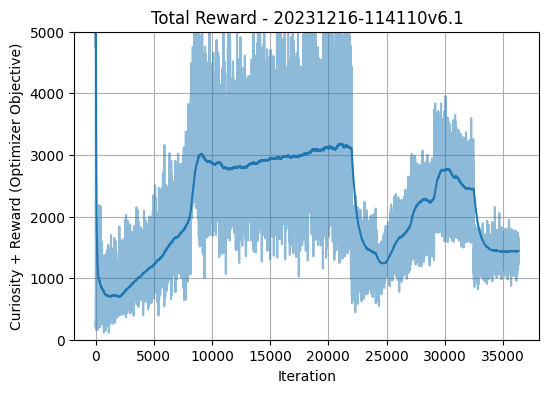

In [392]:
plt.figure(figsize=(6,4))
plt.xlabel('Iteration')
plt.ylabel('Curiosity + Reward (Optimizer Objective)')
plt.title('Total Reward - 20231216-114110v6.1')
plt.grid()
plt.ylim(0, 5000)
total_reward = concat(get_tag(scalars_v6, 'reward')) + concat([concat(get_tag(scalars_v6, 'curiosity_sum')), [0]])
plot_series([total_reward], alpha=0.002)

In [384]:
scalars_v6_scaled = [x.copy() for x in scalars_v6]
for i, scalar in enumerate(scalars_v6_scaled):
    scalar['value'] = scalar['value'] * scale_ratio


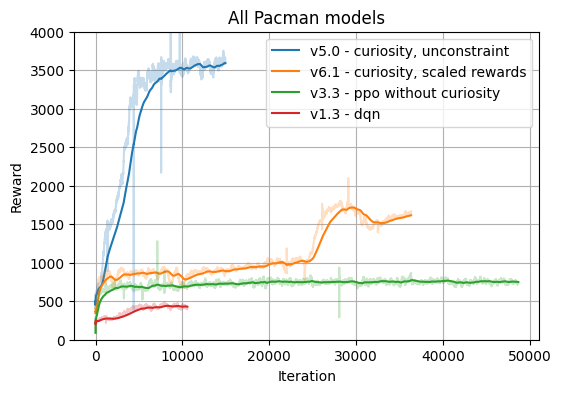

In [391]:
# summirize v5 and v6 on single plot
plt.figure(figsize=(6,4))
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('All Pacman models')
plt.grid()
plt.ylim(0, 4000)

plot_normal('v5.0 - curiosity, unconstraint', 'C0', scalars_v5)
plot_normal('v6.1 - curiosity, scaled rewards', 'C1', scalars_v6_scaled)
plot_normal('v3.3 - ppo without curiosity', 'C2', scalars_4v3)
plot_normal('v1.3 - dqn', 'C3', scalars_v12)
plt.legend()

# Selfplay
v4.0_20231126-140306
v5.0_20231127-090152
v6.0_20231219-150655

In [393]:
# these are doing stuff long and thay have no other runs in chains so can be plotted alone
# selfplay_sessions = [
#     "20231126-140306v4.0",
#     "20231127-090152v5.0",
#     "20231219-150655v6.0",
# ]

# # load runs
# selfplay_runs = [get_training_chain(x) for x in selfplay_sessions]
# selfplay_runs

run: 
    ### 20231126-140306
    #### 2023-11-26 14:03:06
    ---
    ## params
    - env_name: connect_four_v3
- version: v4.0
- DRY_RUN: False
- actor_lr: 1e-06
- critic_lr: 1e-05
- action_space: 7
- observation_space: (6, 7, 2)
- episodes: 100000
- max_steps_per_episode: 100
- discount_rate: 0.99
- eps_decay_len: 5000
- eps_min: 0.1
- clip_ratio: 0.2
- lam: 0.97
- batch_size: 2000
- train_interval: 10
- iters: 1
- save_freq: 1000
- eval_freq: 1000
- copy_player_freq: 1000
- update_historic_freq: 5000
- train_on_historic_freq: 4
    
run: 
    ### 20231127-090152
    #### 2023-11-27 09:01:53
    ---
    ## params
    - env_name: connect_four_v3
- version: v5.0
- DRY_RUN: False
- actor_lr: 1e-07
- critic_lr: 1e-05
- action_space: 7
- observation_space: (6, 7, 2)
- episodes: 5000000
- max_steps_per_episode: 100
- discount_rate: 0.98
- eps_decay_len: 5000
- eps_min: 0.1
- clip_ratio: 0.2
- lam: 0.95
- batch_size: 2000
- train_interval: 1
- iters: 80
- save_freq: 3000
- eval_freq: 1000


[['20231126-140306v4.0'], ['20231127-090152v5.0'], ['20231219-150655v6.0']]

In [395]:
selfplay_runs = ['20231126-140306v4.0', '20231127-090152v5.0', '20231219-150655v6.0']

In [397]:
# load v4 scalars
scalars_v4_selfplay = load_scalars('20231126-140306v4.0')

In [398]:
scalars_v4_selfplay

,step,tag,value
0,180,critic_loss,0.917147
1,190,critic_loss,0.907460
2,200,critic_loss,0.901724
3,210,critic_loss,0.907700
4,220,critic_loss,0.907797
...,...,...,...
551181,99995,reward_p2,-1.000000
551182,99996,reward_p2,1.000000
551183,99997,reward_p2,-1.000000
551184,99998,reward_p2,-1.000000


In [403]:
scalars_v4_selfplay['tag'].unique()

array(['critic_loss', 'kl', 'lenght', 'loss', 'mean_clipped_ratio',
       'mean_logprob', 'mean_ratio', 'reward', 'reward_avg',
       'reward_avg_p2', 'reward_p2'], dtype=object)

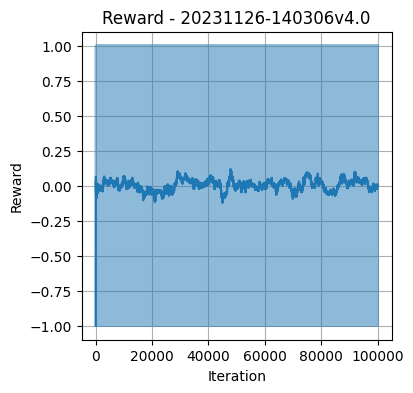

In [401]:
# plot reward
plt.figure(figsize=(4,4))
rewards = get_tag([scalars_v4_selfplay], 'reward')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231126-140306v4.0')
plt.grid()
plot_series(rewards, alpha=0.001)

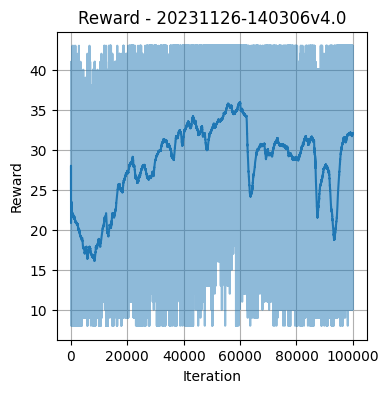

In [407]:
# plot reward
plt.figure(figsize=(4,4))
rewards = get_tag([scalars_v4_selfplay], 'lenght')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231126-140306v4.0')
plt.grid()
plot_series(rewards, alpha=0.001)

In [409]:
scalars_v5_selfplay = load_scalars('20231127-090152v5.0')

In [410]:
scalars_v5_selfplay['tag'].unique()

array(['critic_loss', 'kl', 'lenght', 'loss', 'mean_clipped_ratio',
       'mean_logprob', 'mean_ratio', 'reward', 'reward_avg',
       'reward_avg_p2', 'reward_p2'], dtype=object)

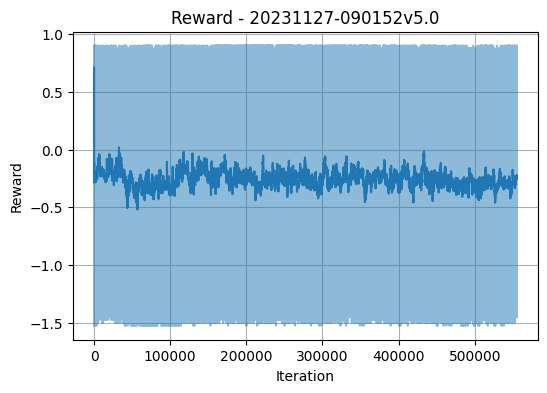

In [417]:
plt.figure(figsize=(6,4))
rewards = get_tag([scalars_v5_selfplay], 'reward')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231127-090152v5.0')
plt.grid()
plot_series(rewards, alpha=0.001)

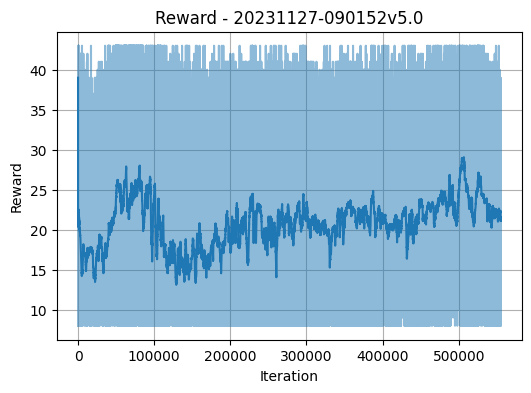

In [418]:
plt.figure(figsize=(6,4))
rewards = get_tag([scalars_v5_selfplay], 'lenght')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward - 20231127-090152v5.0')
plt.grid()
plot_series(rewards, alpha=0.001)

In [425]:
scalars_v6_selfplay = load_scalars('20231219-150655v6.0')

In [426]:
scalars_v6_selfplay['tag'].unique()

array(['critic_loss', 'curiosity_loss', 'curiosity_mean', 'curiosity_std',
       'kl', 'lenght', 'loss', 'mean_clipped_ratio', 'mean_logprob',
       'mean_ratio', 'reward', 'reward_avg', 'reward_avg_p2', 'reward_p2'],
      dtype=object)

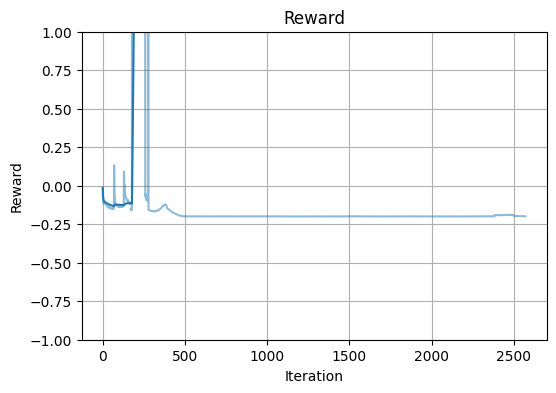

In [431]:
plt.figure(figsize=(6,4))
rewards = get_tag([scalars_v6_selfplay], 'loss')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward')
plt.ylim(-1, 1)
plt.grid()
plot_series(rewards, alpha=0.001)